In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

---------------------------

## Config

In [4]:
import sys

In [5]:
project_dir = '/home/pmonteagudo/workspace/silencing_project'
if project_dir not in sys.path: 
    sys.path.append(project_dir)
from config_analysis import *

In [6]:
import Util

<font color='blue'> **Visualization is a bit slow!** </font>

In [7]:
visualize_distributions=True
#visualize_distributions=False

<font color='red'> **Important! - Don't forget to change to corresponding analysis** </font>

Select **RNA polymerase II antibody** used in: `[S2, S5]`
* Chromatin Immunoprecipitation (**ChIP**)
* RNA Immunoprecipitation (**RIP**)

In [8]:
ip_type = 'S2'
#ip_type = 'S5'

<font color='red'> **Attention!** for `H3K9me2` samples It's possible to use other directories than the default (e.g. `ChIP/h3k9me2`) </font>

For analysis of H3K9me2 (only **Pol II ChIP fold changes** possible)

In [9]:
h3k9me2_analysis=False
#h3k9me2_analysis=True

In [10]:
h3k9me2_dir = 'h3k9me2' # use longest 3 mRNA genes
h3k9me2_dir = 'strict_mean_h3k9me2'
h3k9me2_dir = 'strict_median_h3k9me2'
#h3k9me2_dir = 'strict_q98_h3k9me2'
#h3k9me2_dir = 'strict_q95_h3k9me2'
#h3k9me2_dir = 'wo_ip_subtraction_h3k9me2'

<font color='red'> **Attention!** Include shift in ratios? Deal with **division by zero** </font>
\begin{equation}
\dfrac{x}{y} \sim \dfrac{\delta x + x}{\delta y + y}
\end{equation}

In [11]:
shift_ratio = 0 # compute ratio (x/y)
#shift_ratio = 1 # compute ratio (1 + x)/(1 + y)

- Result **directories**

In [12]:
#rna_dir = os.path.join(project_data_dir, 'results/xp_data/RNA')
rna_dir = rna_dir
rna_dir

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/RNA'

In [13]:
#chip_dir = os.path.join(project_data_dir, 'results/xp_data/ChIP')
chip_dir = chip_dir
if h3k9me2_analysis:
    chip_dir = os.path.join(chip_dir, h3k9me2_dir)
chip_dir

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/ChIP'

In [14]:
#ratios_dir = os.path.join(project_data_dir, 'results/Ratios')
ratios_dir = ratios_dir
if h3k9me2_analysis:
    ratios_dir = os.path.join(ratios_dir, h3k9me2_dir)
    if not os.path.exists(ratios_dir):    
        os.makedirs(ratios_dir)
ratios_dir

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios'

------

- Import dataframe containing **annotation of all samples**

In [15]:
#sample_annotation_file = os.path.join(project_data_dir, 'seq_data', 'sample_annotation.csv')
sample_annotation_file = os.path.join(project_data_dir, 'seq_data', 'file_annotation.csv')
sample_annotation_file

'/gcm-lfs1/pablo/data/rna_silencing/seq_data/file_annotation.csv'

In [16]:
#select_cols = ['sample_id', 'pipeline_type', 'seq_category', 'seq_type',  'mutant_id', 'mutant', 'replicate', 'batch', 'trimmed', 'halic_local_dir']
select_cols = ['sample_id', 'pipeline_type', 'seq_category', 'seq_type',  'mutant_id', 'mutant_name', 'replicate', 'trimmed']

In [17]:
all_samples_df = pd.read_csv(sample_annotation_file, sep="\t", usecols=select_cols)[select_cols]
#all_samples_df = pd.read_csv(sample_annotation_file, sep="\t")
all_samples_df.rename(columns={'mutant_name':'mutant'}, inplace=True)
#all_samples_df.head()

In [18]:
all_samples_df.shape

(157, 8)

- **Ignore specific samples** 

In [19]:
all_samples_df = all_samples_df[~all_samples_df.sample_id.isin(ignore_datasets)]
all_samples_df.shape

(156, 8)

- **Ignore S2-RIP/S5-RIP samples** for now

In [20]:
#all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S2-RIP']
#all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S5-RIP']
#all_samples_df.shape

- **Ignore S2-ChIP/S5-ChIP samples** for now

In [21]:
#all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S2-ChIP']
#all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S5-ChIP']
#all_samples_df.shape

- Select **RNA Datasets**: | S2-RIP | S5-RIP | pA-RNA | total-RNA |

In [22]:
rna_datasets_df = all_samples_df[all_samples_df['pipeline_type'] == 'RNA']

# add 'sub_sample' column
# => Atention! it's a bit tricky due to ambiguity between `mutant_id -> mutant` map
rna_datasets_df.loc[:, 'mutant_group'] = rna_datasets_df.mutant.map(inv_mut_dict)
rna_datasets_df.loc[:, 'sub_sample'] = rna_datasets_df['mutant_group'] + '_' + rna_datasets_df['seq_type']

rna_datasets_df.head()

/home/pmonteagudo/anaconda3/envs/heterochromatin/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/pmonteagudo/anaconda3/envs/heterochromatin/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,sample_id,pipeline_type,seq_category,seq_type,mutant_id,mutant,replicate,trimmed,mutant_group,sub_sample
4,1022_S2-RIP_2,RNA,S2-RIP,S2-RIP,1022,mot2d,2,False,1022,1022_S2-RIP
5,1022_S2-RIP_3,RNA,S2-RIP,S2-RIP,1022,mot2d,3,False,1022,1022_S2-RIP
6,1022_S2-RIP_4,RNA,S2-RIP,S2-RIP,1022,mot2d,4,False,1022,1022_S2-RIP
7,1022_S2-RIP_5,RNA,S2-RIP,S2-RIP,1022,mot2d,5,False,1022,1022_S2-RIP
8,1022_pA-RNA_1,RNA,pA-RNA,pA-RNA,1022,mot2d,1,False,1022,1022_pA-RNA


In [23]:
rna_datasets_df.shape

(80, 10)

In [24]:
##rna_datasets_df[['sample_id', 'mutant_id', 'mutant']].groupby(['mutant', 'mutant_id']).count()
#rna_datasets_df[['sample_id', 'mutant_id', 'mutant_group']].groupby(['mutant_group', 'mutant_id']).count()

- Select **ChIP Datasets**: | S2-ChIP | S5-ChIP | H3K9me2 |

In [25]:
chip_datasets_df = all_samples_df[all_samples_df['pipeline_type'] == 'ChIP']

#input_types = ['S2-ChIP-OIN', 'S2-ChIP-INPUT', 'H3K9me2', 'simulated-data']
input_types = ['S2-ChIP-OIN', 'S2-ChIP-INPUT', 'simulated-data']
# distinguish between ChIP and INPUT samples
chip_datasets_df = chip_datasets_df[~chip_datasets_df['seq_type'].isin(input_types)]

# add 'sub_sample' column
# => Atention! it's a bit tricky due to ambiguity between `mutant_id -> mutant` map
chip_datasets_df.loc[:, 'mutant_group'] = chip_datasets_df.mutant.map(inv_mut_dict)
chip_datasets_df.loc[:, 'sub_sample'] = chip_datasets_df['mutant_group'] + '_' + chip_datasets_df['seq_type']

chip_datasets_df.head()

,sample_id,pipeline_type,seq_category,seq_type,mutant_id,mutant,replicate,trimmed,mutant_group,sub_sample
2,1022_S2-ChIP_1,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,1,False,1022,1022_S2-ChIP
3,1022_S2-ChIP_2,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,2,False,1022,1022_S2-ChIP
11,1168_S2-ChIP_1,ChIP,S2-ChIP,S2-ChIP,1168,caf1d*ccr4d*,1,False,1168,1168_S2-ChIP
12,1168_S2-ChIP_2,ChIP,S2-ChIP,S2-ChIP,1168,caf1d*ccr4d*,2,False,1168,1168_S2-ChIP
17,301_H3K9me2_1,ChIP,H3K9me2,H3K9me2,301,swi6d,1,False,301,301_H3K9me2


In [26]:
chip_datasets_df.shape

(42, 10)

In [27]:
##chip_datasets_df[['sample_id', 'mutant_id', 'mutant']].groupby(['mutant', 'mutant_id']).count()
#chip_datasets_df[['sample_id', 'mutant_id', 'mutant_group']].groupby(['mutant_group', 'mutant_id']).count()

-------------

# Calculate Ratio Analysis

This includes the calculation of the following ratios:
- **RNA Stability** (RS): `pA RNA / Pol II RIP`
- **Transcription Efficiency** (TE): `Pol II RIP / Pol II ChIP`
- **Pol II ChIP fold changes** (delta_chip) between Mutant groups

-------------

# **A.** RNA stability (RS)

**Calculate ratio:** `pA RNA / Pol II RIP`

-------------

- Get **pairs** for ratio definition

In [28]:
#rs_pairs = rna_datasets_df[rna_datasets_df['seq_type'].isin(['pA-RNA', 'S2-RIP'])]
rs_pairs = rna_datasets_df[rna_datasets_df['seq_type'].isin([ip_type + '-RIP', 'pA-RNA'])]
rs_pairs = rs_pairs[['sub_sample', 'mutant_group']].drop_duplicates()

# Order is very important!!!!
rs_pairs['ratio_order'] = rs_pairs['sub_sample'].apply(lambda x: 0 if 'pA-RNA' in x else 1)
rs_pairs = rs_pairs.sort_values(['mutant_group', 'ratio_order']).reset_index(drop=True)

rs_pairs = dict(rs_pairs.groupby('mutant_group')['sub_sample'].apply(list))
#rs_pairs

- Make sure each element is a **pair**

In [29]:
n_pairs = len(rs_pairs)

rs_pairs = {key:value for (key, value) in rs_pairs.items() if len(value) == 2}
print('Removed pairs:', n_pairs - len(rs_pairs))

rs_pairs

Removed pairs: 0


{'1022': ['1022_pA-RNA', '1022_S2-RIP'],
 '1168': ['1168_pA-RNA', '1168_S2-RIP'],
 '301': ['301_pA-RNA', '301_S2-RIP'],
 '302': ['302_pA-RNA', '302_S2-RIP'],
 '324': ['324_pA-RNA', '324_S2-RIP'],
 '491': ['491_pA-RNA', '491_S2-RIP'],
 '504': ['504_pA-RNA', '504_S2-RIP'],
 '510': ['510_pA-RNA', '510_S2-RIP'],
 '523': ['523_pA-RNA', '523_S2-RIP'],
 '530': ['530_pA-RNA', '530_S2-RIP'],
 '544': ['544_pA-RNA', '544_S2-RIP'],
 '638': ['638_pA-RNA', '638_S2-RIP'],
 '80': ['80_pA-RNA', '80_S2-RIP'],
 'WT': ['WT_pA-RNA', 'WT_S2-RIP']}

- Get `samples` **columns**

In [30]:
sample_cols = []
{sample_cols.extend(value) for (key, value) in rs_pairs.items()}
assert len(sample_cols) == 2 * len(rs_pairs)
assert len(sample_cols) == len(set(sample_cols))
len(sample_cols)
#sample_cols

28

- Import **RNA** merged **gene expression Matrix** per Mutant type: `rna_merged_tpm.csv`

In [31]:
id_vars = ["gene_id", "gene_name", "length", "type", "category", "bio_type"]

In [32]:
rna_tpm_file = os.path.join(rna_dir, 'rna_merged_tpm.csv')
rna_tpm_file

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/RNA/rna_merged_tpm.csv'

In [33]:
tpm_df = pd.read_csv(
    rna_tpm_file, 
    sep='\t', 
    comment='#',
    usecols=id_vars + sample_cols,
    dtype={kk:'float64' for kk in sample_cols}
)
tpm_df.head()

,gene_id,gene_name,length,type,category,bio_type,1022_S2-RIP,1022_pA-RNA,1168_S2-RIP,1168_pA-RNA,...,530_S2-RIP,530_pA-RNA,544_S2-RIP,544_pA-RNA,638_S2-RIP,638_pA-RNA,80_S2-RIP,80_pA-RNA,WT_S2-RIP,WT_pA-RNA
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,13.047263,8.610194,1.551187,0.812477,...,2.302027,0.818856,6.413489,0.889646,2.628246,2.906437,2.941590,1.800442,2.451086,0.719070
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,4.362461,5.435505,6.791771,1.182042,...,5.855969,13.501304,11.787602,2.451016,5.225105,10.515522,4.632683,1.165227,29.076151,6.204396
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,20.357270,57.937164,8.811443,83.772135,...,14.649701,25.659982,11.068837,41.728144,4.224988,6.463253,18.242957,37.932886,0.999979,8.761472
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
tpm_df.shape

(7021, 34)

#### <font color='red'> Deal with **NAs**: *Drop* or *fill with zeros?* </font>
- <font color='red'> `NaN's` originated from zero counts: **fill with zeros** </font>
- <font color='red'> In `rna_merged_tpm.csv`, it should already have been taken care of! </font> 

In [35]:
# (NOT USED)
# => NAs originated from zero counts: fill with zeros
#tpm_df = tpm_df.fillna(0) # undesired off-target effects to other columns (e.g. `gene_name`)
#tpm_df = tpm_df.fillna({kk:0 for kk in sample_cols})

# (NOT USED) drop row (axis - 0) if it finds ANY `na`, becareful when adding new columns!
#tpm_df = tpm_df.dropna(subset = sample_cols) 
#tpm_df = tpm_df.dropna(0)

In [36]:
# no surprises!
# => there should not be NAs in sample columns (with counts)
assert not tpm_df[sample_cols].isnull().values.any()

Keep only **Heterochromatic** and **protein coding genes** (mRNA)

In [37]:
#tpm_df = tpm_df[(tpm_df['type'] == 'gene') | (tpm_df['category'] == 'repeat')]
tpm_df = tpm_df[(tpm_df['bio_type'] == 'mRNA') | (tpm_df['category'] == 'repeat')]
tpm_df.shape

(5159, 34)

- <font color='blue'> **RNA and RIP** </font> - Before computing ratios compute **summary statistics**

In [38]:
# Summarize statistics
summary_rs_tpm_df = tpm_df.describe(percentiles=[.25, .5, .75, .95])[sample_cols]
summary_rs_tpm_df

,1022_pA-RNA,1022_S2-RIP,1168_pA-RNA,1168_S2-RIP,301_pA-RNA,301_S2-RIP,302_pA-RNA,302_S2-RIP,324_pA-RNA,324_S2-RIP,...,530_pA-RNA,530_S2-RIP,544_pA-RNA,544_S2-RIP,638_pA-RNA,638_S2-RIP,80_pA-RNA,80_S2-RIP,WT_pA-RNA,WT_S2-RIP
count,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,...,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000
mean,188.393801,98.605671,189.407530,87.010071,185.244849,98.517989,188.261512,106.942659,186.789457,110.163430,...,185.885385,101.248753,189.510108,122.702238,186.003308,99.006266,186.275944,94.023437,188.785962,101.599510
std,470.981746,170.391467,430.269944,130.657799,706.454611,166.822283,630.667336,181.827658,650.329859,192.783428,...,662.847787,176.525622,496.237202,212.219536,651.839388,219.109979,658.314845,173.390398,557.778532,198.697203
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.023850,35.267337,40.034550,29.884998,27.362611,36.277927,27.736766,36.272432,28.901501,39.074034,...,29.034383,32.773204,34.774411,46.477777,31.480345,28.200323,30.281666,31.554165,31.544092,32.110015
50%,79.647068,58.138156,83.378067,54.209726,57.277308,58.858061,58.995001,60.951737,60.740055,63.937988,...,61.726181,55.909471,72.873833,78.198419,63.302449,49.970127,64.405473,52.148747,64.524421,55.192312
75%,162.594990,96.827754,176.365188,96.248229,132.025168,99.401439,132.978638,106.466770,138.365803,109.557422,...,140.727027,98.089573,159.274158,131.089998,138.623298,89.253966,141.075565,89.896025,141.825275,98.941223
95%,600.972345,319.610845,604.727223,279.244680,575.718266,299.891402,615.764160,347.103018,577.954782,345.514466,...,581.442342,349.010481,611.229134,351.451134,586.075046,354.343933,579.721826,317.171684,588.060394,329.048978
max,9866.456591,4339.526239,8138.041262,2818.022114,19475.584411,3074.854831,16787.795023,3408.364888,16779.282540,3665.431355,...,17364.862563,2867.244478,10315.557504,7223.405663,18771.074079,5141.329964,19656.727469,3461.146262,12652.720262,4445.979712


- <font color='blue'> **RNA and RIP** </font> - Before computing ratios **visualize distributions**

In [39]:
tpm_tidy_df = pd.melt(tpm_df, id_vars = id_vars, var_name = 'sample_id', value_name = 'count')
tpm_tidy_df = tpm_tidy_df.astype({'count':'float64'})

# add 'seq_category' column
tpm_tidy_df.loc[:, 'seq_category'] = [ss.split('_')[1] for ss in tpm_tidy_df['sample_id']]
# add 'sub_sample' column
# => Atention! it's a bit tricky due to ambiguity between `mutant_id -> mutant` map
tpm_tidy_df.loc[:, 'mutant_id'] = [ss.split('_')[0] for ss in tpm_tidy_df['sample_id']]
tpm_tidy_df.loc[:, 'mutant'] = tpm_tidy_df.mutant_id.map(mut_dict)

tpm_tidy_df.head()

,gene_id,gene_name,length,type,category,bio_type,sample_id,count,seq_category,mutant_id,mutant
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,1022_S2-RIP,13.047263,S2-RIP,1022,mot2d
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,1022_S2-RIP,0.000000,S2-RIP,1022,mot2d
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1022_S2-RIP,4.362461,S2-RIP,1022,mot2d
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,1022_S2-RIP,20.357270,S2-RIP,1022,mot2d
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,1022_S2-RIP,0.000000,S2-RIP,1022,mot2d


In [40]:
tpm_tidy_df.shape

(144452, 11)

In [41]:
#tpm_tidy_df['seq_category'].unique()
#tpm_tidy_df['mutant_id'].unique()
#tpm_tidy_df['mutant'].unique()

In [42]:
max_count = summary_rs_tpm_df.loc['95%'].max()
#max_count = 10
print('Upper threshold for count values (otherwise it take forever):', max_count)

Upper threshold for count values (otherwise it take forever): 616.5587570107108


/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/rna_rip_dist.pdf


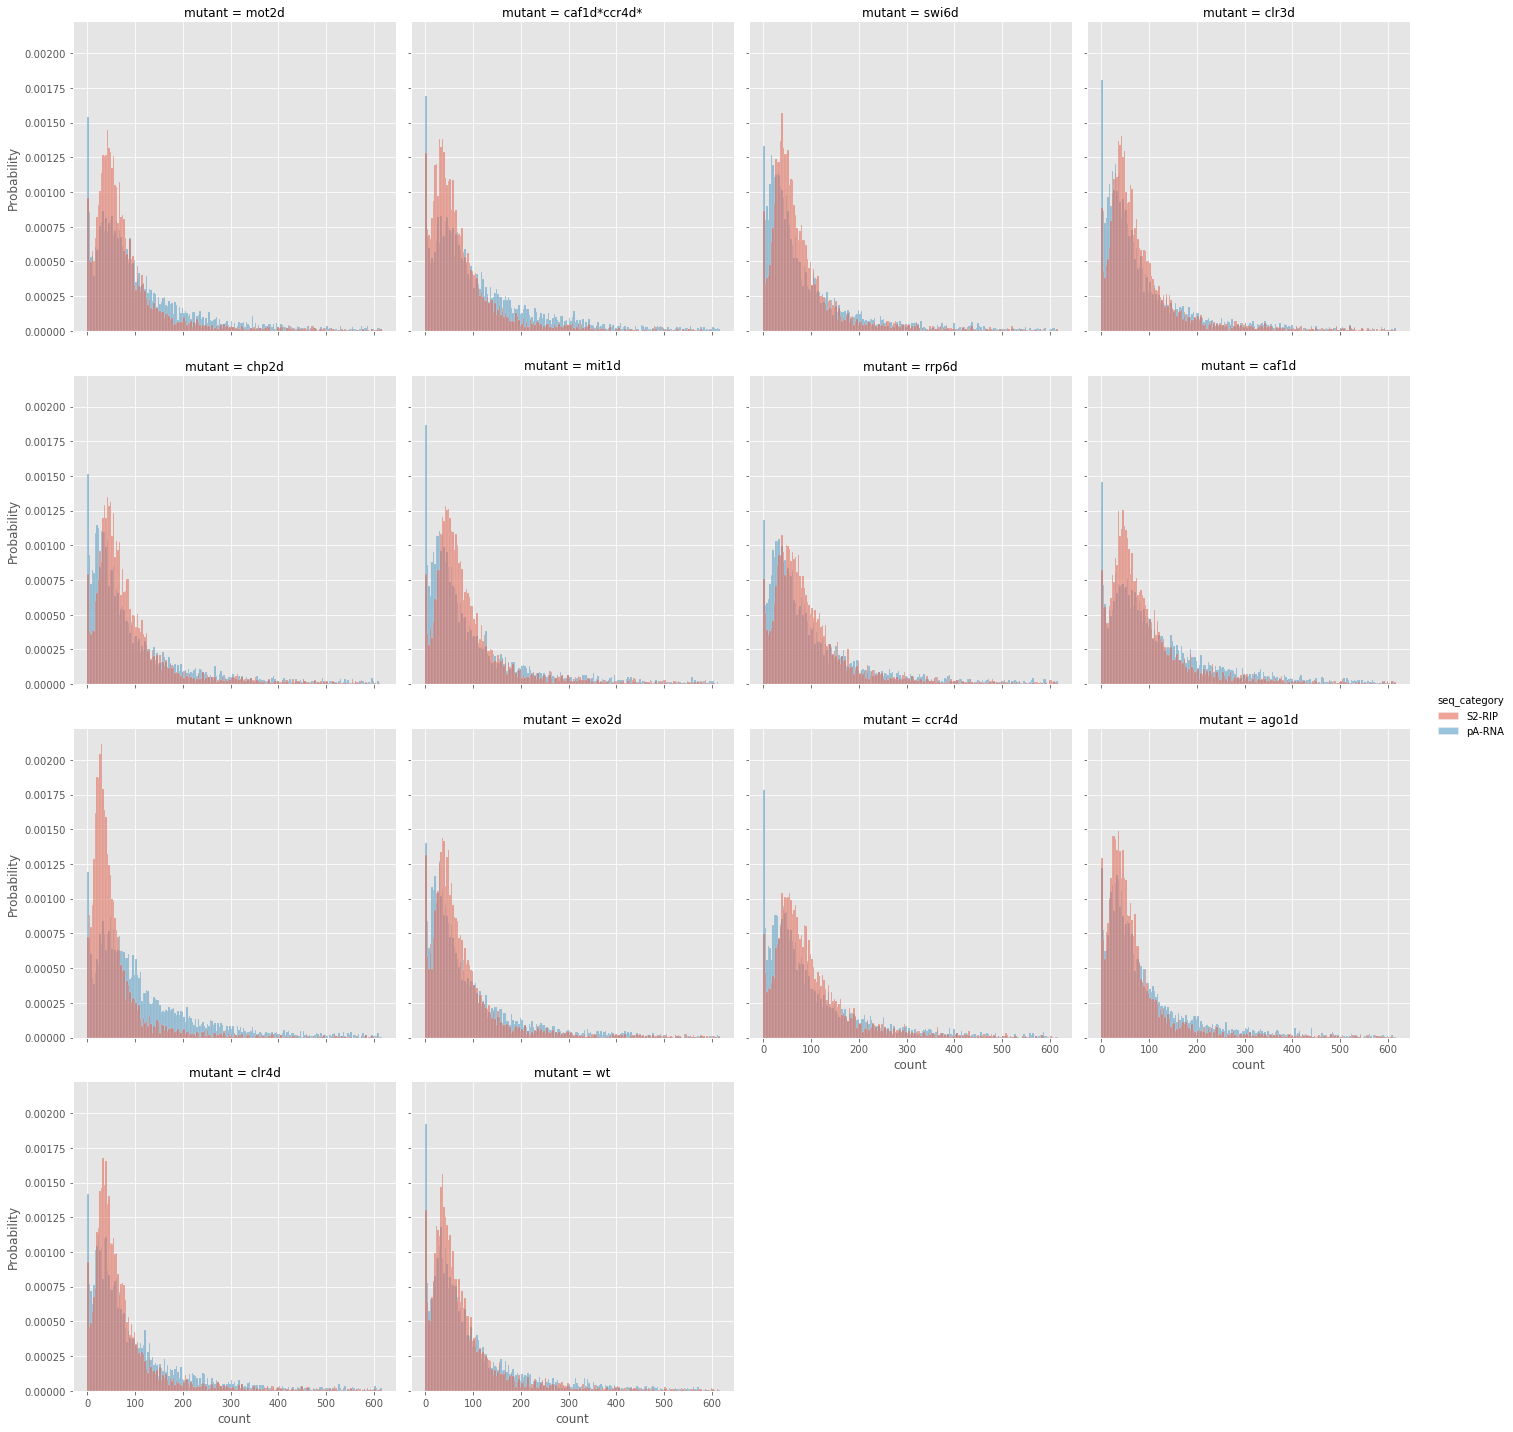

In [43]:
if (visualize_distributions):
    
    dist_plot = sns.displot(
        #data=tpm_tidy_df, 
        data=tpm_tidy_df[tpm_tidy_df['count'] < max_count], 
        x="count", 
        hue="seq_category", 
        col="mutant",
        col_wrap=4,
        stat="probability",
        #bins=200
    )
    
    rna_rip_dist_fig = os.path.join(ratios_dir, 'rna_rip_dist.pdf')
    print(rna_rip_dist_fig)
    dist_plot.savefig(rna_rip_dist_fig)

- <font color='blue'> **RNA Stability (RS)** </font> -  Compute actual **ratios** for defined **pairing**:

In [44]:
rna_stability_file = ip_type + '-rna_stability.csv' if ip_type == 'S5' else 'rna_stability.csv'
rna_stability_file
os.path.join(ratios_dir, rna_stability_file)

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/rna_stability.csv'

In [45]:
print('Use shift ratio:', shift_ratio)
#rs_table = Util.ratio_table(tpm_df, pairs, 
rs_table = Util.ratio_table(
    tpm_df, rs_pairs, 
    #new_cols = col_names,
    out_dir = ratios_dir, 
    #file_name = 'rna_stability.csv')                            
    file_name = rna_stability_file,
    #shift=0 # compute ratio (x/y)
    #shift=1 # compute ratio (1 + x)/(1 + y)
    shift=shift_ratio # compute ratio (1 + x)/(1 + y)
)

Use shift ratio: 0


In [46]:
rs_table.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,80,WT
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,0.659923,0.523778,0.272456,0.265005,0.405359,0.455835,0.385234,0.732856,1.556545,0.355711,0.138715,1.105847,0.612064,0.293368
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1.245972,0.174040,0.893177,0.529501,0.528688,0.495048,0.972946,0.891789,0.218474,2.305563,0.207932,2.012500,0.251523,0.213384
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,2.846018,9.507199,6.065400,1.695289,2.261381,0.240024,0.085662,4.142059,4.926130,1.751570,3.769876,1.529768,2.079317,8.761658
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
rs_table.shape

(5159, 20)

- Get `samples` **columns**

In [48]:
sample_cols = []
{sample_cols.append(key) for (key, value) in rs_pairs.items()}
len(sample_cols)
#sample_cols

14

- Problems in **ratios**

In [49]:
# zeros in numerator - 0/y
# => also converted to NaN's should be empty
rs_table[(rs_table[sample_cols] == 0).any(axis=1)].shape

(0, 20)

In [50]:
# zeros in denominator - x/0
rs_table[(rs_table[sample_cols].isnull()).any(axis=1)].shape

(110, 20)

- <font color='blue'> **RNA Stability (RS)** </font> - Compute **summary statistics** for RS ratios

In [51]:
# Summarize statistics
summary_rs_tpm_df = rs_table.describe(percentiles=[.25, .5, .75, .95])[sample_cols]
summary_rs_tpm_df

,1022,1168,301,302,324,491,504,510,523,530,544,638,80,WT
count,5098.000000,5082.000000,5109.000000,5101.000000,5105.000000,5101.000000,5101.000000,5102.000000,5104.000000,5087.000000,5103.000000,5100.000000,5107.000000,5087.000000
mean,1.868093,2.639969,1.925392,1.559279,1.708674,1.611418,1.593069,1.979548,2.825829,1.995179,1.542170,2.249368,2.143053,1.944976
std,1.778528,3.623793,3.142694,1.990695,2.411375,2.261511,2.098225,2.184083,2.517182,2.724401,2.016864,3.134334,3.019847,2.396484
min,0.007835,0.004874,0.006097,0.001453,0.003423,0.001521,0.005804,0.005384,0.000428,0.008273,0.002559,0.004980,0.001406,0.004863
25%,0.785706,0.822186,0.483684,0.507082,0.471940,0.457689,0.490976,0.685527,1.291384,0.576416,0.476124,0.695948,0.618544,0.612422
50%,1.340870,1.572339,0.942792,0.962115,0.917470,0.907065,0.951788,1.296419,2.140522,1.107594,0.924472,1.283236,1.198197,1.173237
75%,2.320165,3.097219,2.052034,1.856530,1.958755,1.878579,1.815169,2.450070,3.469977,2.287612,1.854371,2.467741,2.407476,2.293727
95%,5.323917,8.444498,6.763763,4.802877,5.829513,5.253621,5.339223,6.061776,7.585255,6.742881,4.783464,7.405409,7.313324,6.188396
max,18.740127,79.227206,44.130048,30.262072,32.553484,32.005129,27.009426,31.535532,29.512992,38.183755,35.095947,39.493333,39.823533,31.887650


- <font color='blue'> **RNA Stability (RS)** </font> - **Visualize distributions** of RS ratios

In [52]:
rs_tidy_df = pd.melt(rs_table, id_vars = id_vars, var_name = 'sample_id', value_name = 'count')
rs_tidy_df = rs_tidy_df.astype({'count':'float64'})

# => Atention! it's a bit tricky due to ambiguity between `mutant_id -> mutant` map
rs_tidy_df.loc[:, 'mutant_id'] = rs_tidy_df['sample_id']
rs_tidy_df.loc[:, 'mutant'] = rs_tidy_df.mutant_id.map(mut_dict)

rs_tidy_df.head()

,gene_id,gene_name,length,type,category,bio_type,sample_id,count,mutant_id,mutant
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,1022,0.659923,1022,mot2d
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,1022,NaN,1022,mot2d
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1022,1.245972,1022,mot2d
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,1022,2.846018,1022,mot2d
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,1022,NaN,1022,mot2d


In [53]:
rs_tidy_df.shape

(72226, 10)

In [54]:
#rs_tidy_df['seq_category'].unique()
#rs_tidy_df['mutant_id'].unique()
#rs_tidy_df['mutant'].unique()

In [55]:
max_count = summary_rs_tpm_df.loc['95%'].max()
#max_count = 10
print('Upper threshold for count values (otherwise it take forever):', max_count)

Upper threshold for count values (otherwise it take forever): 8.44449765441134


/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/rs_ratios_dist.pdf


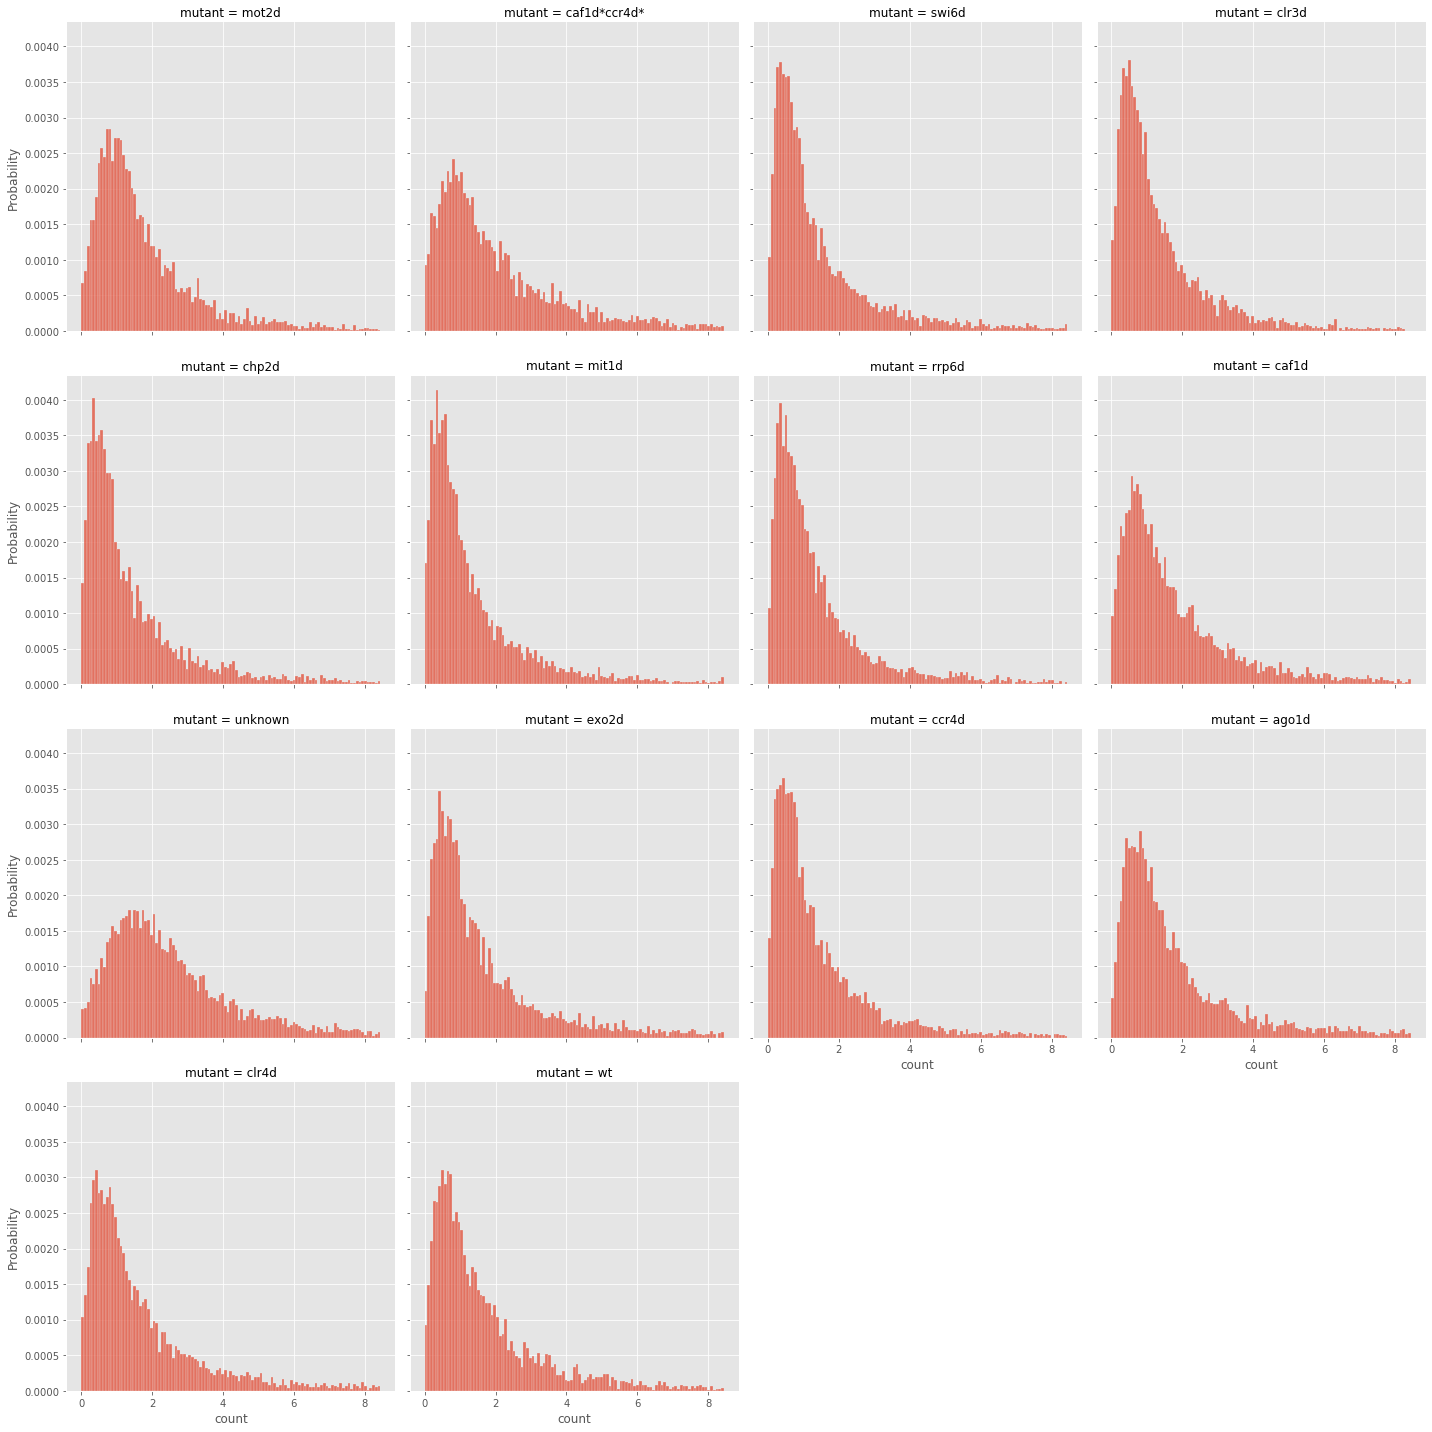

In [56]:
if (visualize_distributions):
    
    dist_plot = sns.displot(
        #data=rs_tidy_df,
        data=rs_tidy_df[rs_tidy_df['count'] < max_count], 
        x="count", 
        #hue="seq_category", 
        col="mutant",
        col_wrap=4,
        stat="probability",
        #bins=200
    )
    
    rs_dist_fig = os.path.join(ratios_dir, 'rs_ratios_dist.pdf')
    print(rs_dist_fig)
    dist_plot.savefig(rs_dist_fig)

---

# **B.** Transcription Efficiency (TE)

**Calculate ratio:** `Pol II RIP / Pol II ChIP`

---

- Get **pairs** for ratio definition

In [57]:
# RIP
#rna_te = rna_datasets_df[rna_datasets_df['seq_type'].isin(['S2-RIP'])][['sub_sample', 'mutant_group']].drop_duplicates()
rna_te = rna_datasets_df[rna_datasets_df['seq_type'].isin([ip_type + '-RIP'])][['sub_sample', 'mutant_group']].drop_duplicates()

# ChIP
if not h3k9me2_analysis:
    #chip_te = chip_datasets_df[chip_datasets_df['seq_type'].isin(['S2-ChIP'])][['sub_sample', 'mutant_group']].drop_duplicates()
    chip_te = chip_datasets_df[chip_datasets_df['seq_type'].isin([ip_type + '-ChIP'])][['sub_sample', 'mutant_group']].drop_duplicates()
else:
    chip_te = chip_datasets_df[chip_datasets_df['seq_type'].isin(['H3K9me2'])][['sub_sample', 'mutant_group']].drop_duplicates()

In [58]:
#rna_te
#chip_te

In [59]:
# RIP / ChIP pairs
te_pairs = pd.concat([rna_te, chip_te], axis=0)

# Attention!
# => Order is very important!
te_pairs['ratio_order'] = te_pairs['sub_sample'].apply(lambda x: 0 if 'RIP' in x else 1)
te_pairs = te_pairs.sort_values(['mutant_group', 'ratio_order']).reset_index(drop=True)

te_pairs = dict(te_pairs.groupby('mutant_group')['sub_sample'].apply(list))
#te_pairs

- Make sure each element is a **pair**

In [60]:
n_pairs = len(te_pairs)

te_pairs = {key:value for (key,value) in te_pairs.items() if len(value) == 2}
print('Removed pairs:', n_pairs - len(te_pairs))

te_pairs

Removed pairs: 0


{'1022': ['1022_S2-RIP', '1022_S2-ChIP'],
 '1168': ['1168_S2-RIP', '1168_S2-ChIP'],
 '301': ['301_S2-RIP', '301_S2-ChIP'],
 '302': ['302_S2-RIP', '302_S2-ChIP'],
 '324': ['324_S2-RIP', '324_S2-ChIP'],
 '491': ['491_S2-RIP', '491_S2-ChIP'],
 '504': ['504_S2-RIP', '504_S2-ChIP'],
 '510': ['510_S2-RIP', '510_S2-ChIP'],
 '523': ['523_S2-RIP', '523_S2-ChIP'],
 '530': ['530_S2-RIP', '530_S2-ChIP'],
 '544': ['544_S2-RIP', '544_S2-ChIP'],
 '638': ['638_S2-RIP', '638_S2-ChIP'],
 '80': ['80_S2-RIP', '80_S2-ChIP'],
 'WT': ['WT_S2-RIP', 'WT_S2-ChIP']}

- Get `samples` **columns**

In [61]:
sample_cols = []
{sample_cols.extend(value) for (key, value) in te_pairs.items()}
assert len(sample_cols) == 2 * len(te_pairs)
assert len(sample_cols) == len(set(sample_cols))
len(sample_cols)
#sample_cols

28

- Get **rna** and **chip** `samples` **columns**

In [62]:
rna_sample_cols = []
{rna_sample_cols.append(value[0]) for (key, value) in te_pairs.items()}
chip_sample_cols = []
{chip_sample_cols.append(value[1]) for (key, value) in te_pairs.items()}
assert len(rna_sample_cols) == len(chip_sample_cols)
assert len(rna_sample_cols) == len(set(chip_sample_cols))
len(rna_sample_cols)
#rna_sample_cols
#chip_sample_cols

14

#### **A.** Import **RNA** merged **gene expression Matrix** per Mutant type: `rna_merged_tpm.csv`

In [63]:
id_vars = ["gene_id", "gene_name", "length", "type", "category", "bio_type"]

In [64]:
rna_tpm_file = os.path.join(rna_dir, 'rna_merged_tpm.csv')
rna_tpm_file

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/RNA/rna_merged_tpm.csv'

In [65]:
tpm_df = pd.read_csv(
    rna_tpm_file,
    sep='\t',
    #usecols=id_vars + rna_te['sub_sample'].tolist(),
    usecols=id_vars + rna_sample_cols,
    dtype={kk:'float64' for kk in sample_cols}
)
tpm_df.head()

,gene_id,gene_name,length,type,category,bio_type,1022_S2-RIP,1168_S2-RIP,301_S2-RIP,302_S2-RIP,324_S2-RIP,491_S2-RIP,504_S2-RIP,510_S2-RIP,523_S2-RIP,530_S2-RIP,544_S2-RIP,638_S2-RIP,80_S2-RIP,WT_S2-RIP
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,13.047263,1.551187,4.332981,2.118607,4.065520,4.321674,6.039716,5.129676,7.059774,2.302027,6.413489,2.628246,2.941590,2.451086
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.981490,0.000000,0.000000,0.000000,0.000000,0.000000
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,4.362461,6.791771,16.536449,8.528136,16.328247,12.056912,54.899838,3.715484,15.787251,5.855969,11.787602,5.225105,4.632683,29.076151
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,20.357270,8.811443,8.181341,3.503321,15.052789,6.948553,2.542961,13.633320,12.824000,14.649701,11.068837,4.224988,18.242957,0.999979
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [66]:
tpm_df.shape

(7021, 20)

Keep only **Heterochromatic** and **protein coding** (mRNA) genes

In [67]:
#tpm_df = tpm_df[(tpm_df['type'] == 'gene') | (tpm_df['category'] == 'repeat')]
tpm_df = tpm_df[(tpm_df['bio_type'] == 'mRNA') | (tpm_df['category'] == 'repeat')]
tpm_df.shape

(5159, 20)

#### **B.** Import **ChIP** merged **gene expression Matrix** per Mutant type: `chip_merged_tpm.csv`

In [68]:
id_vars = ["gene_id", "gene_name", "length", "type", "category", "bio_type"]

In [69]:
chip_tpm_file =  os.path.join(chip_dir, 'chip_merged_tpm.csv')
chip_tpm_file

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/ChIP/chip_merged_tpm.csv'

In [70]:
chip_df = pd.read_csv(
    chip_tpm_file, 
    sep='\t',
    #usecols=id_vars + chip_te['sub_sample'].tolist(),
    usecols=id_vars + chip_sample_cols,
    dtype={kk:'float64' for kk in sample_cols}
)
chip_df.head()

,gene_id,gene_name,length,type,category,bio_type,1022_S2-ChIP,1168_S2-ChIP,301_S2-ChIP,302_S2-ChIP,324_S2-ChIP,491_S2-ChIP,504_S2-ChIP,510_S2-ChIP,523_S2-ChIP,530_S2-ChIP,544_S2-ChIP,638_S2-ChIP,80_S2-ChIP,WT_S2-ChIP
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,36.353199,31.604013,25.447595,34.155106,48.796624,78.338895,82.344549,22.183831,131.192765,75.910257,8.783881,26.188978,20.314666,53.476467
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,32.989946,0.000000,101.717017,55.581202,39.056446,0.000000,35.620283,25.716713,30.158095,112.748997,9.204962,0.000000,0.000000,207.093084
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,55.543018,35.786011,42.055579,103.330550,149.072861,91.264382,284.326357,53.698150,259.546526,177.695904,47.749498,100.410479,33.232083,53.214594
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,57.460638,10.993232,40.619884,31.836483,58.392030,66.456588,55.698312,29.545178,112.472071,114.430437,23.119050,31.980414,44.331171,62.637044
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,105.639842,26.961737,21.862377,54.908906,115.970265,9.481100,44.786774,49.165672,240.632152,150.771303,115.088074,162.738097,90.572514,51.058611


In [71]:
chip_df.shape

(7021, 20)

Keep only **Heterochromatic** and **protein coding genes** (mRNA)

In [72]:
#chip_df = chip_df[(chip_df['type'] == 'gene') | (chip_df['category'] == 'repeat')]
chip_df = chip_df[(chip_df['bio_type'] == 'mRNA') | (chip_df['category'] == 'repeat')]
chip_df.shape

(5159, 20)

#### **C.** **Merge ChIP** and **RNA** gene expression Matrices:

In [73]:
id_vars = ["gene_id", "gene_name", "length", "type", "category", "bio_type"]

In [74]:
#tpm_df = pd.merge(chip_df, tpm_df, on=['gene-id', 'gene-name', 'type', 'category', 'bio_type'])
tpm_df = pd.merge(chip_df, tpm_df, on=id_vars)
tpm_df.head()

,gene_id,gene_name,length,type,category,bio_type,1022_S2-ChIP,1168_S2-ChIP,301_S2-ChIP,302_S2-ChIP,...,324_S2-RIP,491_S2-RIP,504_S2-RIP,510_S2-RIP,523_S2-RIP,530_S2-RIP,544_S2-RIP,638_S2-RIP,80_S2-RIP,WT_S2-RIP
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,36.353199,31.604013,25.447595,34.155106,...,4.065520,4.321674,6.039716,5.129676,7.059774,2.302027,6.413489,2.628246,2.941590,2.451086
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,32.989946,0.000000,101.717017,55.581202,...,0.000000,0.000000,0.000000,0.000000,34.981490,0.000000,0.000000,0.000000,0.000000,0.000000
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,55.543018,35.786011,42.055579,103.330550,...,16.328247,12.056912,54.899838,3.715484,15.787251,5.855969,11.787602,5.225105,4.632683,29.076151
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,57.460638,10.993232,40.619884,31.836483,...,15.052789,6.948553,2.542961,13.633320,12.824000,14.649701,11.068837,4.224988,18.242957,0.999979
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,105.639842,26.961737,21.862377,54.908906,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [75]:
tpm_df.shape

(5159, 34)

#### <font color='red'> Deal with **NAs**: *Drop* or *fill with zeros?* </font>
- <font color='red'> `NaN's` originated from zero counts: **fill with zeros** </font>
- <font color='red'> In both `rna_merged_tpm.csv` and `chip_merged_tpm.csv`, it should already have been taken care of! </font> 

In [76]:
# (NOT USED)
# => NAs originated from zero counts: fill with zeros
#tpm_df = tpm_df.fillna(0) # undesired off-target effects to other columns (e.g. `gene_name`)
#tpm_df = tpm_df.fillna({kk:0 for kk in sample_cols})

# (NOT USED) drop row (axis - 0) if it finds ANY `na`, becareful when adding new columns!
#tpm_df = tpm_df.dropna(subset = sample_cols) 
#tpm_df = tpm_df.dropna(0)

In [77]:
# no surprises!
# => there should not be NAs in sample columns (with counts)
assert not tpm_df[sample_cols].isnull().values.any()

- <font color='blue'> **RIP and ChIP** </font> - Before computing ratios compute **summary statistics**

In [78]:
# Summarize statistics
summary_te_tpm_df = tpm_df.describe(percentiles=[.25, .5, .75, .95])[sample_cols]
summary_te_tpm_df

,1022_S2-RIP,1022_S2-ChIP,1168_S2-RIP,1168_S2-ChIP,301_S2-RIP,301_S2-ChIP,302_S2-RIP,302_S2-ChIP,324_S2-RIP,324_S2-ChIP,...,530_S2-RIP,530_S2-ChIP,544_S2-RIP,544_S2-ChIP,638_S2-RIP,638_S2-ChIP,80_S2-RIP,80_S2-ChIP,WT_S2-RIP,WT_S2-ChIP
count,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,...,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000
mean,98.605671,152.303930,87.010071,150.448622,98.517989,157.861290,106.942659,156.935222,110.163430,154.315764,...,101.248753,156.108068,122.702238,156.123531,99.006266,155.141736,94.023437,156.453782,101.599510,157.932298
std,170.391467,199.592528,130.657799,199.992035,166.822283,190.008405,181.827658,195.194252,192.783428,182.277306,...,176.525622,199.486962,212.219536,221.441633,219.109979,206.408056,173.390398,199.408451,198.697203,204.438407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.267337,69.975374,29.884998,62.928108,36.277927,79.937849,36.272432,66.154428,39.074034,74.445255,...,32.773204,69.908217,46.477777,75.963358,28.200323,73.121244,31.554165,71.403999,32.110015,71.678909
50%,58.138156,109.073048,54.209726,106.597097,58.858061,119.369182,60.951737,108.617840,63.937988,113.290161,...,55.909471,108.038353,78.198419,115.231068,49.970127,109.501310,52.148747,112.620286,55.192312,115.715861
75%,96.827754,166.596609,96.248229,171.908066,99.401439,173.886186,106.466770,173.533230,109.557422,167.111496,...,98.089573,165.828313,131.089998,168.994264,89.253966,165.080199,89.896025,170.619007,98.941223,175.502700
95%,319.610845,408.508984,279.244680,404.292592,299.891402,384.518626,347.103018,452.243139,345.514466,407.554277,...,349.010481,467.773645,351.451134,378.678298,354.343933,411.746392,317.171684,410.445599,329.048978,410.516740
max,4339.526239,5533.651200,2818.022114,5659.662268,3074.854831,3702.347434,3408.364888,3887.436477,3665.431355,4040.827945,...,2867.244478,3445.095366,7223.405663,6307.057920,5141.329964,3539.881997,3461.146262,3472.799813,4445.979712,5270.515434


<font color='red'> **Note: notice the big difference in `max` values between `H3K9me2` and `RIP` data** </font>

- <font color='blue'> **RIP and ChIP** </font> - Before computing ratios **visualize distributions**

In [79]:
tpm_tidy_df = pd.melt(tpm_df, id_vars = id_vars, var_name = 'sample_id', value_name = 'count')
tpm_tidy_df = tpm_tidy_df.astype({'count':'float64'})

# add 'seq_category' column
tpm_tidy_df.loc[:, 'seq_category'] = [ss.split('_')[1] for ss in tpm_tidy_df['sample_id']]
# add 'sub_sample' column
# => Atention! it's a bit tricky due to ambiguity between `mutant_id -> mutant` map
tpm_tidy_df.loc[:, 'mutant_id'] = [ss.split('_')[0] for ss in tpm_tidy_df['sample_id']]
tpm_tidy_df.loc[:, 'mutant'] = tpm_tidy_df.mutant_id.map(mut_dict)

tpm_tidy_df.head()

,gene_id,gene_name,length,type,category,bio_type,sample_id,count,seq_category,mutant_id,mutant
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,1022_S2-ChIP,36.353199,S2-ChIP,1022,mot2d
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,1022_S2-ChIP,32.989946,S2-ChIP,1022,mot2d
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1022_S2-ChIP,55.543018,S2-ChIP,1022,mot2d
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,1022_S2-ChIP,57.460638,S2-ChIP,1022,mot2d
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,1022_S2-ChIP,105.639842,S2-ChIP,1022,mot2d


In [80]:
tpm_tidy_df.shape

(144452, 11)

In [81]:
#tpm_tidy_df['seq_category'].unique()
#tpm_tidy_df['mutant_id'].unique()
#tpm_tidy_df['mutant'].unique()

In [82]:
max_count = summary_te_tpm_df.loc['95%'].max()
#max_count = 10
print('Upper threshold for count values (otherwise it take forever):', max_count)

Upper threshold for count values (otherwise it take forever): 467.77364540754166


/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/rip_chip_dist.pdf


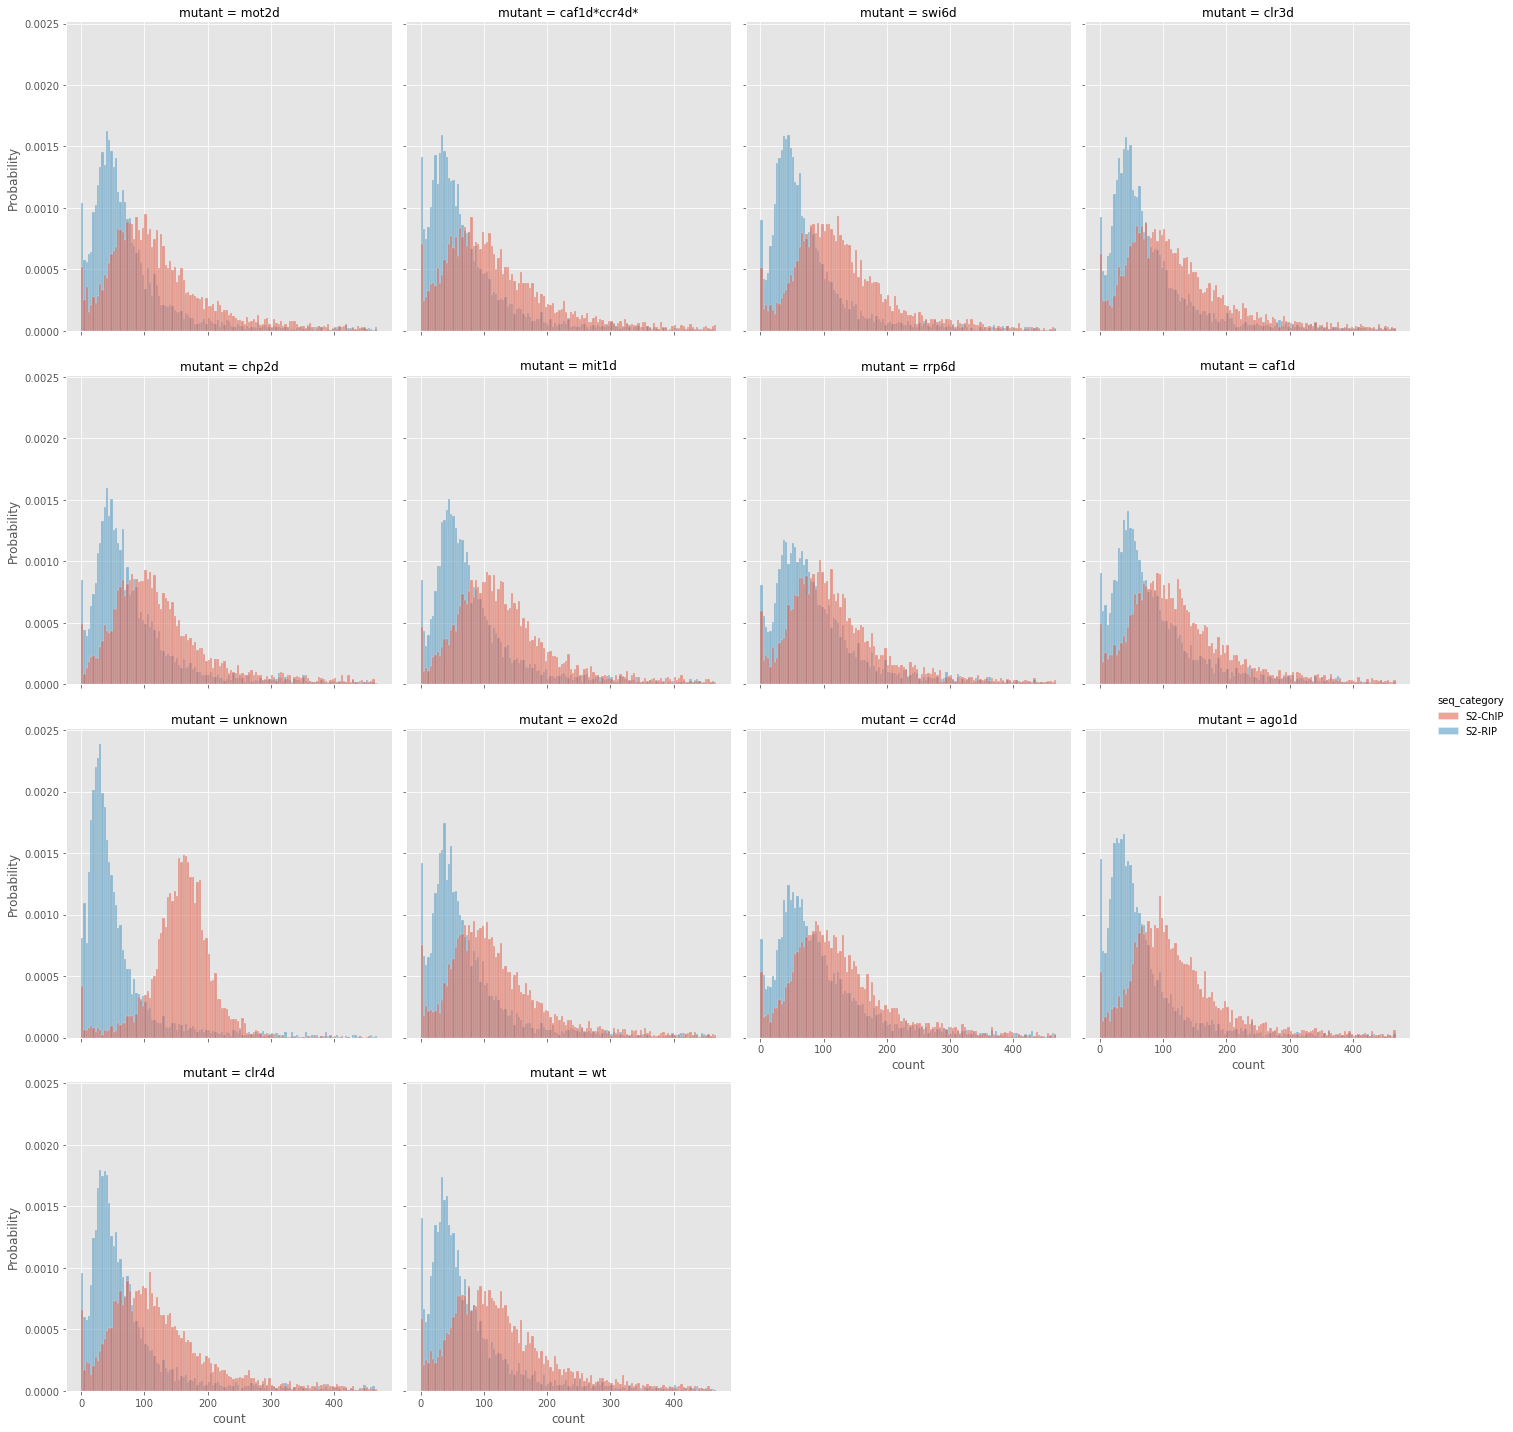

In [83]:
if (visualize_distributions):
    
    dist_plot = sns.displot(
        #data=tpm_tidy_df,
        data=tpm_tidy_df[tpm_tidy_df['count'] < max_count], 
        x="count", 
        hue="seq_category", 
        col="mutant",
        col_wrap=4,
        #col_wrap=3,
        stat="probability",
        #bins=200
    )
    
    rip_chip_dist_fig = os.path.join(ratios_dir, 'rip_chip_dist.pdf')
    print(rip_chip_dist_fig)
    dist_plot.savefig(rip_chip_dist_fig)

- Compute actual **ratios** for defined **pairing**:

In [84]:
transcription_efficiency_file = ip_type + '-transcription_efficiency.csv' if ip_type == 'S5' else 'transcription_efficiency.csv'
transcription_efficiency_file
os.path.join(ratios_dir, transcription_efficiency_file)

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/transcription_efficiency.csv'

In [85]:
print('Use shift ratio:', shift_ratio)

te_table = Util.ratio_table(
    tpm_df, te_pairs,
    out_dir=ratios_dir, 
    #file_name='transcription_efficiency.csv',
    file_name=transcription_efficiency_file,
    #shift=0 # compute ratio (x/y)
    #shift=1 # compute ratio (1 + x)/(1 + y)
    shift=shift_ratio # compute ratio (1 + x)/(1 + y)
)

Use shift ratio: 0


In [86]:
te_table.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,80,WT
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,0.358903,0.049082,0.170271,0.062029,0.083316,0.055166,0.073347,0.231235,0.053812,0.030326,0.730143,0.100357,0.144801,0.045835
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.159937,NaN,NaN,NaN,NaN,NaN
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,0.078542,0.189788,0.393205,0.082533,0.109532,0.132110,0.193087,0.069192,0.060826,0.032955,0.246863,0.052037,0.139404,0.546394
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,0.354282,0.801533,0.201412,0.110041,0.257788,0.104558,0.045656,0.461440,0.114019,0.128023,0.478776,0.132112,0.411515,0.015965
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
te_table.shape

(5159, 20)

- Get `samples` **columns**

In [88]:
sample_cols = []
{sample_cols.append(key) for (key, value) in te_pairs.items()}
len(sample_cols)
#sample_cols

14

- Problems in **ratios**

In [89]:
# zeros in numerator - 0/y
# => also converted to NaN's should be empty
te_table[(te_table[sample_cols] == 0).any(axis=1)].shape

(0, 20)

In [90]:
# zeros in denominator - x/0
te_table[(te_table[sample_cols].isnull()).any(axis=1)].shape # notice that, for H3K9me2 is huge, all mRNA genes!
#te_table[(~te_table[sample_cols].isnull()).all(axis=1)]

(134, 20)

- <font color='blue'> **Transcription Efficiency (TE)** </font> - Compute **summary statistics** for TE ratios

In [91]:
# Summarize statistics
summary_te_tpm_df = te_table.describe(percentiles=[.25, .5, .75, .95])[sample_cols]
summary_te_tpm_df

,1022,1168,301,302,324,491,504,510,523,530,544,638,80,WT
count,5095.000000,5082.000000,5099.000000,5093.000000,5096.000000,5097.000000,5089.000000,5093.000000,5097.000000,5061.000000,5101.000000,5088.000000,5097.000000,5079.000000
mean,0.654726,0.668296,0.585548,0.657921,0.663364,0.674402,0.838831,0.699551,0.410824,0.639927,0.800477,0.550349,0.575106,0.609860
std,0.422492,0.687597,0.320936,0.428945,0.346691,1.016162,0.605872,0.403770,0.614190,0.555057,0.511440,0.360137,0.518935,0.604069
min,0.002763,0.006984,0.013493,0.016086,0.027980,0.007880,0.008768,0.015741,0.005823,0.005344,0.008207,0.005948,0.008322,0.005562
25%,0.384636,0.335456,0.381542,0.441422,0.431349,0.422898,0.494402,0.429831,0.166558,0.391908,0.501427,0.336085,0.359676,0.353284
50%,0.587137,0.549298,0.530810,0.619746,0.618136,0.598701,0.764638,0.640588,0.255795,0.588245,0.751786,0.504816,0.525083,0.544475
75%,0.832512,0.840779,0.716106,0.804806,0.826872,0.804576,1.075299,0.892445,0.406371,0.802896,1.021313,0.697546,0.698785,0.761183
95%,1.336624,1.469544,1.111892,1.167776,1.252743,1.241924,1.657301,1.371375,1.221684,1.193479,1.483895,1.117525,1.062164,1.220885
max,7.150075,26.852538,4.971680,19.161857,4.120535,55.968758,22.005836,5.228542,12.699703,24.510154,15.469675,11.211524,23.917385,31.149262


- <font color='blue'> **Transcription Efficiency (TE)** </font> - **Visualize distributions** of TE ratios

In [92]:
te_tidy_df = pd.melt(te_table, id_vars = id_vars, var_name = 'sample_id', value_name = 'count')
te_tidy_df = te_tidy_df.astype({'count':'float64'})

# => Atention! it's a bit tricky due to ambiguity between `mutant_id -> mutant` map
te_tidy_df.loc[:, 'mutant_id'] = te_tidy_df['sample_id']
te_tidy_df.loc[:, 'mutant'] = te_tidy_df.mutant_id.map(mut_dict)

te_tidy_df.head()

,gene_id,gene_name,length,type,category,bio_type,sample_id,count,mutant_id,mutant
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,1022,0.358903,1022,mot2d
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,1022,NaN,1022,mot2d
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1022,0.078542,1022,mot2d
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,1022,0.354282,1022,mot2d
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,1022,NaN,1022,mot2d


In [93]:
te_tidy_df.shape

(72226, 10)

In [94]:
#te_tidy_df['seq_category'].unique()
#te_tidy_df['mutant_id'].unique()
#te_tidy_df['mutant'].unique()

In [95]:
max_count = summary_te_tpm_df.loc['95%'].max()
#max_count = 10
print('Upper threshold for count values (otherwise it take forever):', max_count)

Upper threshold for count values (otherwise it take forever): 1.6573010550463156


/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/te_ratios_dist.pdf


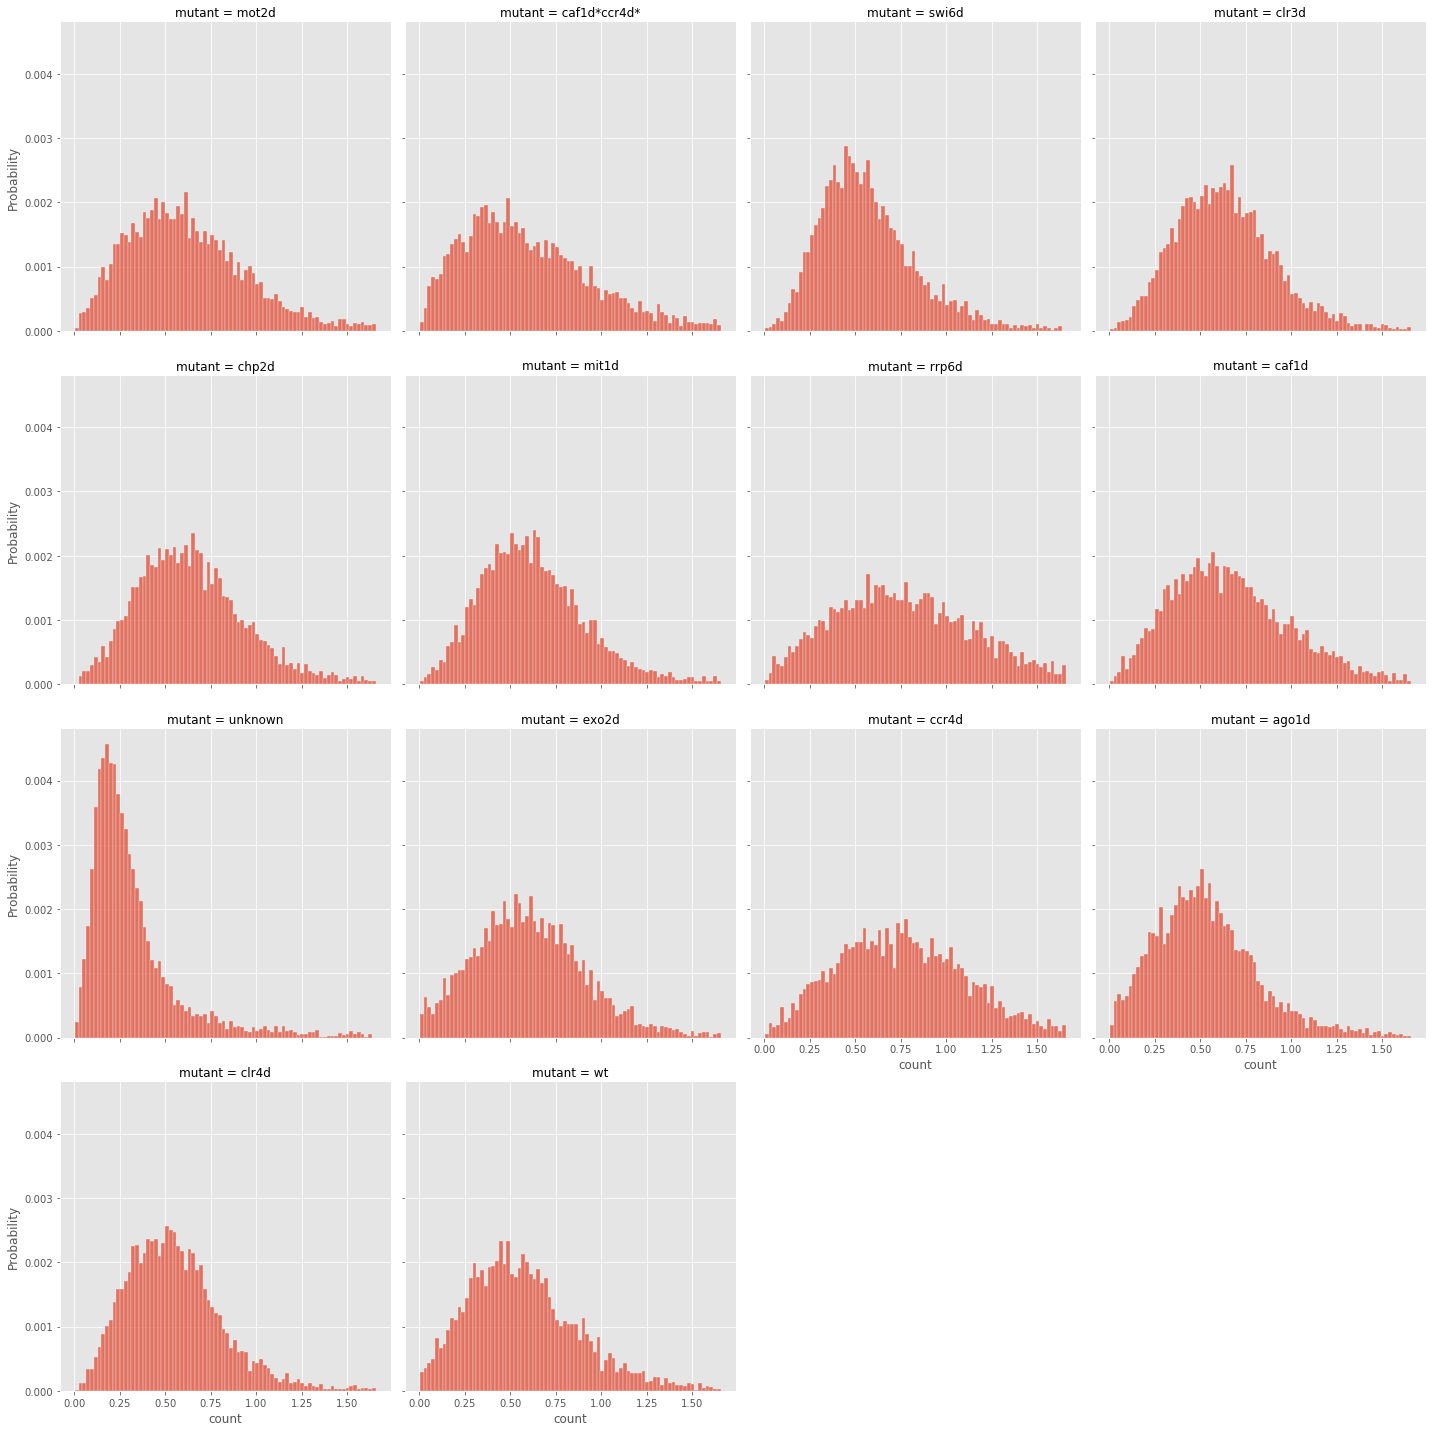

In [96]:
if (visualize_distributions):
    
    dist_plot = sns.displot(
        #data=te_tidy_df, 
        data=te_tidy_df[te_tidy_df['count'] < max_count], 
        x="count", 
        #hue="seq_category", 
        col="mutant",
        col_wrap=4,
        #col_wrap=3,
        stat="probability",
        #bins=200
    )
    
    te_dist_fig = os.path.join(ratios_dir, 'te_ratios_dist.pdf')
    print(te_dist_fig)
    dist_plot.savefig(te_dist_fig)

---

# **C.** Pol II Occupancy fold change (PO)

In this case we define two types of **Pol II ChIP fold changes** (delta_chip):
- `delta_chip_wt`: **mutants / wt**
- `delta_chip_clr4`: **mutants / clr4D**

---

<font color='red'> **Note:** for `H3K9me2` samples this is also well defined. </font>

In [97]:
if (not h3k9me2_analysis):
    #enum_delta_chip = chip_datasets_df[chip_datasets_df['seq_type'].isin(['S2-ChIP'])]['sub_sample'].unique()
    enum_delta_chip = chip_datasets_df[chip_datasets_df['seq_type'].isin([ip_type + '-ChIP'])]['sub_sample'].unique()
else:
    enum_delta_chip = chip_datasets_df[chip_datasets_df['seq_type'] == 'H3K9me2']['sub_sample'].unique()
enum_delta_chip = enum_delta_chip.tolist()
enum_delta_chip

['1022_S2-ChIP',
 '1168_S2-ChIP',
 '301_S2-ChIP',
 '302_S2-ChIP',
 '324_S2-ChIP',
 '491_S2-ChIP',
 '504_S2-ChIP',
 '510_S2-ChIP',
 '523_S2-ChIP',
 '530_S2-ChIP',
 '544_S2-ChIP',
 '638_S2-ChIP',
 '80_S2-ChIP',
 'WT_S2-ChIP']

- `Mutant` type columns:

In [98]:
#col_names = ['638', '1160', '302', '301', '324', '80', '504', '510', '491', '530']
col_names = [xx.split('_')[0] for xx in enum_delta_chip]
#col_names

- Import **ChIP** merged **gene expression Matrix** per Mutant type: `chip_merged_tpm.csv`

In [99]:
id_vars = ["gene_id", "gene_name", "length", "type", "category", "bio_type"]

In [100]:
chip_tpm_file = os.path.join(chip_dir, 'chip_merged_tpm.csv')
chip_tpm_file

'/gcm-lfs1/pablo/data/rna_silencing/results/xp_data/ChIP/chip_merged_tpm.csv'

In [101]:
#chip_df = pd.read_csv(os.path.join(in_dir, 'chip_merged_tpm.csv'), sep='\t')
chip_df = pd.read_csv(
    chip_tpm_file,
    sep='\t',
    comment='#',
    usecols=id_vars + enum_delta_chip,
    dtype={kk:'float64' for kk in enum_delta_chip}
)
chip_df.head()

,gene_id,gene_name,length,type,category,bio_type,1022_S2-ChIP,1168_S2-ChIP,301_S2-ChIP,302_S2-ChIP,324_S2-ChIP,491_S2-ChIP,504_S2-ChIP,510_S2-ChIP,523_S2-ChIP,530_S2-ChIP,544_S2-ChIP,638_S2-ChIP,80_S2-ChIP,WT_S2-ChIP
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,36.353199,31.604013,25.447595,34.155106,48.796624,78.338895,82.344549,22.183831,131.192765,75.910257,8.783881,26.188978,20.314666,53.476467
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,32.989946,0.000000,101.717017,55.581202,39.056446,0.000000,35.620283,25.716713,30.158095,112.748997,9.204962,0.000000,0.000000,207.093084
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,55.543018,35.786011,42.055579,103.330550,149.072861,91.264382,284.326357,53.698150,259.546526,177.695904,47.749498,100.410479,33.232083,53.214594
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,57.460638,10.993232,40.619884,31.836483,58.392030,66.456588,55.698312,29.545178,112.472071,114.430437,23.119050,31.980414,44.331171,62.637044
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,105.639842,26.961737,21.862377,54.908906,115.970265,9.481100,44.786774,49.165672,240.632152,150.771303,115.088074,162.738097,90.572514,51.058611


In [102]:
chip_df.shape

(7021, 20)

#### <font color='red'> Deal with **NAs**: *Drop* or *fill with zeros?* </font>
- <font color='red'> `NaN's` originated from zero counts: **fill with zeros** </font>
- <font color='red'> In `chip_merged_tpm.csv`, it should already have been taken care of! </font> 

In [103]:
# (NOT USED)
# => NAs originated from zero counts: fill with zeros
#chip_df = chip_df.fillna(0) # undesired off-target effects to other columns (e.g. `gene_name`)
#chip_df = chip_df.fillna({kk:0 for kk in sampleenum_delta_chip_cols})

# (NOT USED) drop row (axis - 0) if it finds ANY `na`, becareful when adding new columns!
#chip_df = chip_df.dropna(subset = enum_delta_chip) 
#chip_df = chip_df.dropna(0)

In [104]:
# no surprises!
# => there should not be NAs in sample columns (with counts)
assert not chip_df[enum_delta_chip].isnull().values.any()

Keep only **Heterochromatic** and **protein coding genes** (mRNA)

In [105]:
#chip_df = chip_df[(chip_df['type'] == 'gene') | (chip_df['category'] == 'repeat')]
chip_df = chip_df[(chip_df['bio_type'] == 'mRNA') | (chip_df['category'] == 'repeat')]
chip_df.shape

(5159, 20)

- <font color='blue'> **ChIP** </font> - Before computing ratios compute **summary statistics**

In [106]:
# Summarize statistics
summary_po_tpm_df = chip_df.describe(percentiles=[.25, .5, .75, .95])[enum_delta_chip]
summary_po_tpm_df

,1022_S2-ChIP,1168_S2-ChIP,301_S2-ChIP,302_S2-ChIP,324_S2-ChIP,491_S2-ChIP,504_S2-ChIP,510_S2-ChIP,523_S2-ChIP,530_S2-ChIP,544_S2-ChIP,638_S2-ChIP,80_S2-ChIP,WT_S2-ChIP
count,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000,5159.000000
mean,152.303930,150.448622,157.861290,156.935222,154.315764,156.684127,153.436724,156.784699,160.855948,156.108068,156.123531,155.141736,156.453782,157.932298
std,199.592528,199.992035,190.008405,195.194252,182.277306,168.226070,206.168066,206.673387,66.486704,199.486962,221.441633,206.408056,199.408451,204.438407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.975374,62.928108,79.937849,66.154428,74.445255,80.932739,70.575616,73.710834,133.779573,69.908217,75.963358,73.121244,71.403999,71.678909
50%,109.073048,106.597097,119.369182,108.617840,113.290161,121.627436,109.127001,115.142488,160.967290,108.038353,115.231068,109.501310,112.620286,115.715861
75%,166.596609,171.908066,173.886186,173.533230,167.111496,174.700920,163.922988,174.156422,185.613710,165.828313,168.994264,165.080199,170.619007,175.502700
95%,408.508984,404.292592,384.518626,452.243139,407.554277,396.069247,404.964219,396.355580,235.462180,467.773645,378.678298,411.746392,410.445599,410.516740
max,5533.651200,5659.662268,3702.347434,3887.436477,4040.827945,3926.329096,5353.688844,6939.581921,1401.922707,3445.095366,6307.057920,3539.881997,3472.799813,5270.515434


- <font color='blue'> **ChIP** </font> - Before computing ratios **visualize distributions**

In [107]:
tpm_tidy_df = pd.melt(chip_df, id_vars = id_vars, var_name = 'sample_id', value_name = 'count')
tpm_tidy_df = tpm_tidy_df.astype({'count':'float64'})

# add 'seq_category' column
tpm_tidy_df.loc[:, 'seq_category'] = [ss.split('_')[1] for ss in tpm_tidy_df['sample_id']]
# add 'sub_sample' column
# => Atention! it's a bit tricky due to ambiguity between `mutant_id -> mutant` map
tpm_tidy_df.loc[:, 'mutant_id'] = [ss.split('_')[0] for ss in tpm_tidy_df['sample_id']]
tpm_tidy_df.loc[:, 'mutant'] = tpm_tidy_df.mutant_id.map(mut_dict)

tpm_tidy_df.head()

,gene_id,gene_name,length,type,category,bio_type,sample_id,count,seq_category,mutant_id,mutant
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,1022_S2-ChIP,36.353199,S2-ChIP,1022,mot2d
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,1022_S2-ChIP,32.989946,S2-ChIP,1022,mot2d
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1022_S2-ChIP,55.543018,S2-ChIP,1022,mot2d
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,1022_S2-ChIP,57.460638,S2-ChIP,1022,mot2d
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,1022_S2-ChIP,105.639842,S2-ChIP,1022,mot2d


In [108]:
tpm_tidy_df.shape

(72226, 11)

In [109]:
#tpm_tidy_df['seq_category'].unique()
#tpm_tidy_df['mutant_id'].unique()
#tpm_tidy_df['mutant'].unique()

In [110]:
max_count = summary_po_tpm_df.loc['95%'].max()
#max_count = summary_po_tpm_df.loc['75%'].max()
#max_count = 10
print('Upper threshold for count values (otherwise it take forever):', max_count)

Upper threshold for count values (otherwise it take forever): 467.77364540754166


/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/chip_dist.pdf


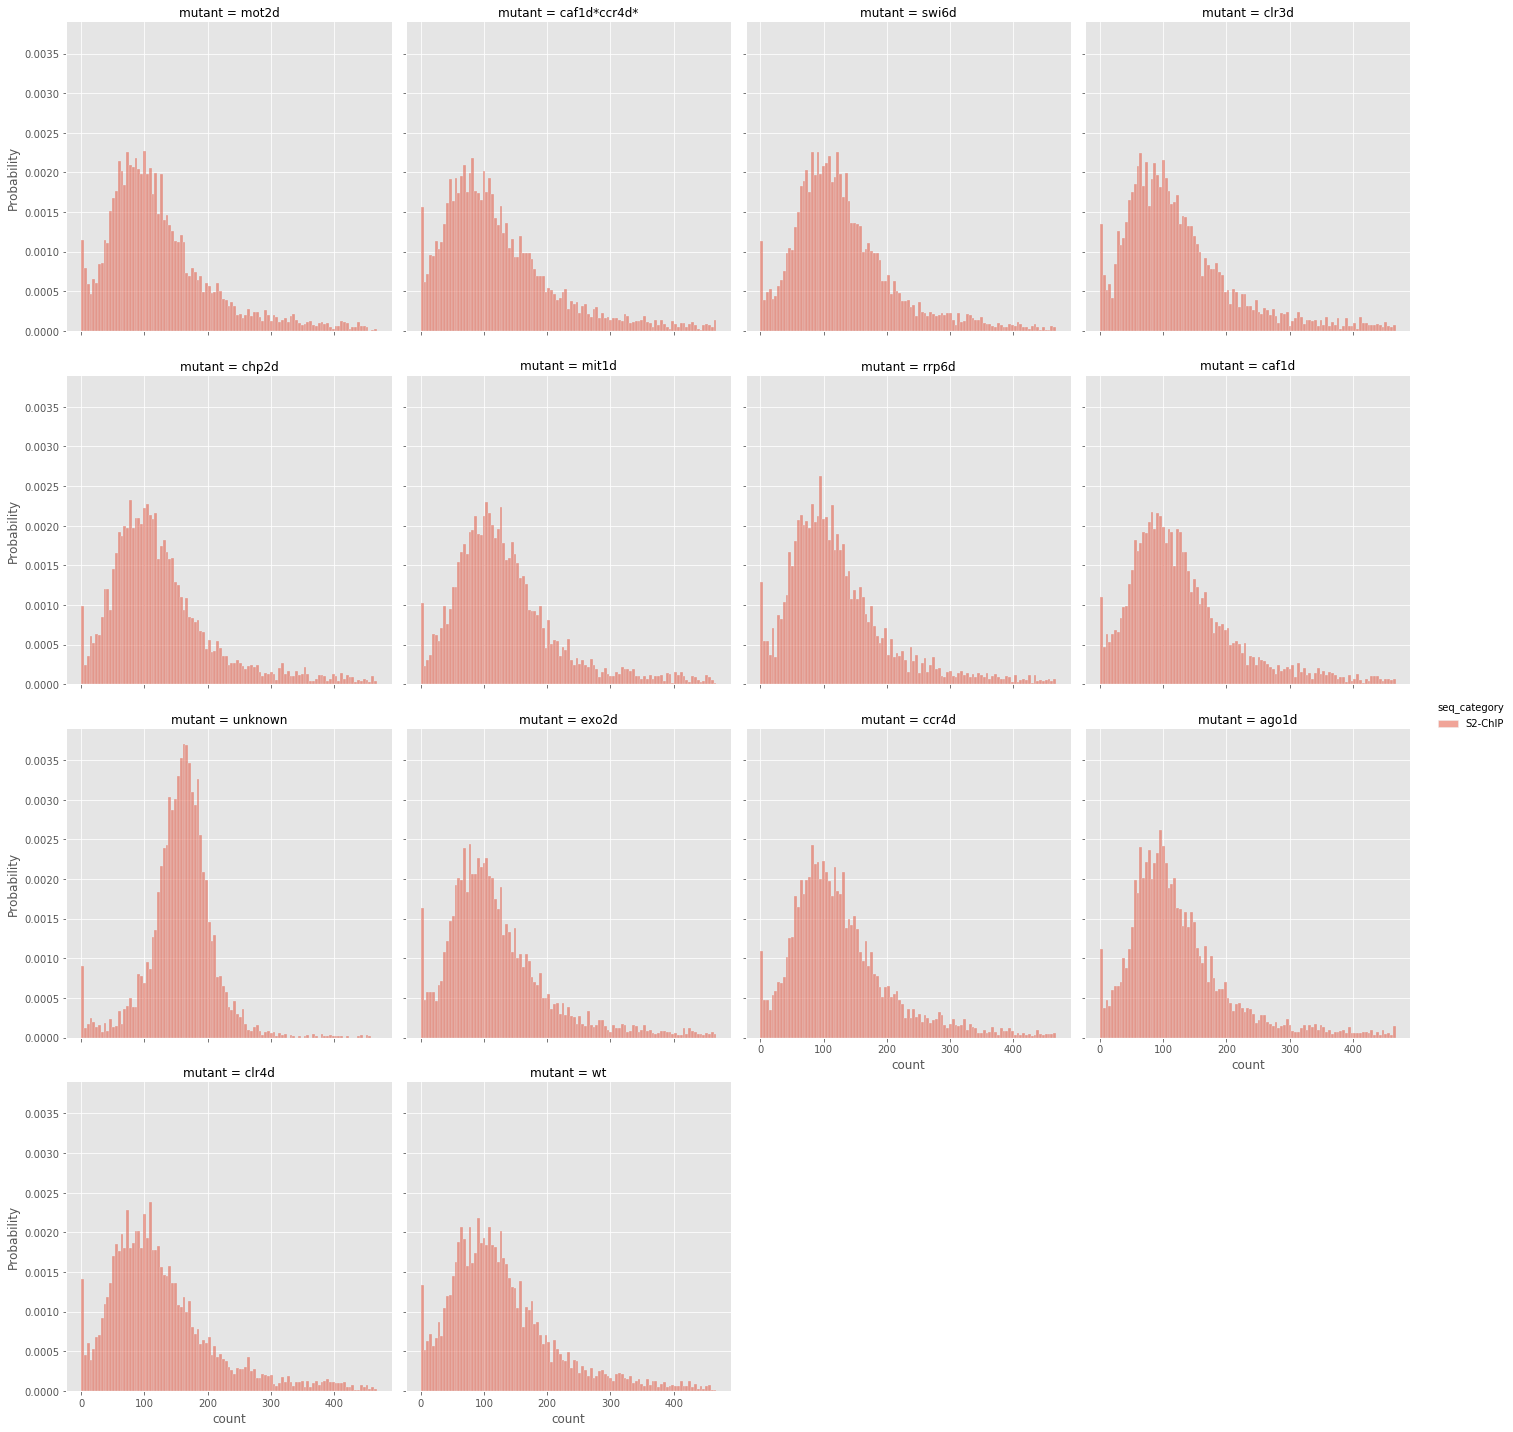

In [111]:
if (visualize_distributions):

    dist_plot = sns.displot(
        #data=tpm_tidy_df, 
        data=tpm_tidy_df[tpm_tidy_df['count'] < max_count], 
        #data=tpm_tidy_df[tpm_tidy_df['count'] > max_count], 
        x="count", 
        hue="seq_category", 
        col="mutant",
        col_wrap=4,
        #col_wrap=3,
        #log_scale=[True, False],
        stat="probability",
        #bins=200
    )
    
    #plt.xlim((0.1, None))
    
    chip_dist_fig = os.path.join(ratios_dir, 'chip_dist.pdf')
    print(chip_dist_fig)
    dist_plot.savefig(chip_dist_fig)

In [112]:
# investigate ago1 (638)
#chip_df[chip_df['638_H3K9me2'] > 10**3]

## **I.** **PO** fold change - `mutants / wt`

- Define pairwise **Ratios** between `WT_ChIP` and the rest of `ChIP` **mutant samples**: 

In [113]:
## fix `WT_ChIP` sample
if (not h3k9me2_analysis):
    #denum = 'WT_S2-ChIP'
    denum = 'WT_' + ip_type + '-ChIP'
else:
    denum = 'WT_H3K9me2'

wt_pairs = {x.split('_')[0]:(x, denum) for x in enum_delta_chip if x != denum}
wt_pairs

{'1022': ('1022_S2-ChIP', 'WT_S2-ChIP'),
 '1168': ('1168_S2-ChIP', 'WT_S2-ChIP'),
 '301': ('301_S2-ChIP', 'WT_S2-ChIP'),
 '302': ('302_S2-ChIP', 'WT_S2-ChIP'),
 '324': ('324_S2-ChIP', 'WT_S2-ChIP'),
 '491': ('491_S2-ChIP', 'WT_S2-ChIP'),
 '504': ('504_S2-ChIP', 'WT_S2-ChIP'),
 '510': ('510_S2-ChIP', 'WT_S2-ChIP'),
 '523': ('523_S2-ChIP', 'WT_S2-ChIP'),
 '530': ('530_S2-ChIP', 'WT_S2-ChIP'),
 '544': ('544_S2-ChIP', 'WT_S2-ChIP'),
 '638': ('638_S2-ChIP', 'WT_S2-ChIP'),
 '80': ('80_S2-ChIP', 'WT_S2-ChIP')}

- Compute actual **ratios** for defined **pairing**:

In [114]:
delta_chip_wt_file = ip_type + '-delta_chip_wt.csv' if ip_type == 'S5' else 'delta_chip_wt.csv'
delta_chip_wt_file
os.path.join(ratios_dir, delta_chip_wt_file)

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/delta_chip_wt.csv'

In [115]:
print('Use shift ratio:', shift_ratio)

delta_chip_wt_df = Util.ratio_table(
    chip_df, wt_pairs, 
    out_dir=ratios_dir, 
    #file_name='delta_chip_wt.csv',
    file_name=delta_chip_wt_file,
    #shift=0 # compute ratio (x/y), values are quite small!
    #shift=1 # compute ratio (1 + x)/(1 + y)
    shift=shift_ratio # compute ratio (1 + x)/(1 + y)
)

Use shift ratio: 0


In [116]:
delta_chip_wt_df.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,80
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,0.679798,0.590989,0.475865,0.638694,0.912488,1.464923,1.539828,0.414834,2.453280,1.419508,0.164257,0.489729,0.379880
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,0.159300,NaN,0.491166,0.268388,0.188594,NaN,0.172001,0.124179,0.145626,0.544436,0.044448,NaN,NaN
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1.043755,0.672485,0.790302,1.941771,2.801353,1.715025,5.343015,1.009087,4.877356,3.339233,0.897301,1.886897,0.624492
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,0.917359,0.175507,0.648496,0.508269,0.932228,1.060979,0.889223,0.471689,1.795616,1.826881,0.369095,0.510567,0.707747
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,2.068992,0.528055,0.428182,1.075409,2.271316,0.185691,0.877164,0.962926,4.712861,2.952906,2.254038,3.187280,1.773893


In [117]:
delta_chip_wt_df.shape

(5159, 19)

In [118]:
#df[df['gene_id'].isin(non_degraded)][[xx for xx in df.columns if ('80' in xx) | (xx == 'gene_id')]]

- Get `samples` **columns**

In [119]:
sample_cols = []
{sample_cols.append(key) for (key, value) in wt_pairs.items()}
len(sample_cols)
#sample_cols

13

- Problems in **ratios**

In [120]:
# zeros in numerator - 0/y
# => also converted to NaN's should be empty
delta_chip_wt_df[(delta_chip_wt_df[sample_cols] == 0).any(axis=1)].shape

(0, 19)

In [121]:
# zeros in denominator - x/0
delta_chip_wt_df[(delta_chip_wt_df[sample_cols].isnull()).any(axis=1)].shape # notice that, for H3K9me2 is huge, all mRNA genes!

(95, 19)

- <font color='blue'> **WT PO fold change** </font> - Compute **summary statistics** for wt PO ratios

In [122]:
# Summarize statistics
summary_wt_po_tpm_df = delta_chip_wt_df.describe(percentiles=[.25, .5, .75, .95])[sample_cols]
summary_wt_po_tpm_df

,1022,1168,301,302,324,491,504,510,523,530,544,638,80
count,5107.000000,5097.000000,5108.000000,5101.000000,5107.000000,5106.000000,5105.000000,5105.000000,5106.000000,5082.000000,5107.000000,5104.000000,5104.000000
mean,1.065288,1.029960,1.101544,1.035913,1.092135,1.165836,1.059532,1.087151,1.871146,1.057551,1.093505,1.084095,1.042449
std,1.864980,1.903377,0.653104,0.898629,0.994312,1.177572,0.939919,1.574222,7.670326,0.930954,0.943396,1.268729,0.801086
min,0.048413,0.017564,0.036333,0.003546,0.012205,0.016811,0.036829,0.097761,0.095694,0.003479,0.044448,0.014520,0.015517
25%,0.824216,0.758048,0.926370,0.845143,0.895022,0.941157,0.817659,0.898613,1.003709,0.810124,0.885013,0.860120,0.888680
50%,0.958147,0.918107,1.031959,0.977987,1.008015,1.066054,0.961878,1.016036,1.363778,0.944869,0.999639,0.965617,0.979985
75%,1.135448,1.126762,1.159998,1.127590,1.149094,1.221451,1.154091,1.149090,1.855662,1.142794,1.152667,1.118769,1.087287
95%,1.627625,1.690286,1.549161,1.501489,1.540538,1.687958,1.613012,1.471001,3.515330,1.787124,1.586744,1.574146,1.391390
max,121.729273,116.572317,31.663475,49.140262,52.877217,51.953754,43.596896,104.717968,483.025950,43.874761,43.072380,68.460952,43.323967


- <font color='blue'> **WT PO fold change** </font> - **Visualize distributions** of wt PO ratios

In [123]:
wt_po_tidy_df = pd.melt(delta_chip_wt_df, id_vars = id_vars, var_name = 'sample_id', value_name = 'count')
wt_po_tidy_df = wt_po_tidy_df.astype({'count':'float64'})

# => Atention! it's a bit tricky due to ambiguity between `mutant_id -> mutant` map
wt_po_tidy_df.loc[:, 'mutant_id'] = wt_po_tidy_df['sample_id']
wt_po_tidy_df.loc[:, 'mutant'] = wt_po_tidy_df.mutant_id.map(mut_dict)

wt_po_tidy_df.head()

,gene_id,gene_name,length,type,category,bio_type,sample_id,count,mutant_id,mutant
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,1022,0.679798,1022,mot2d
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,1022,0.159300,1022,mot2d
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1022,1.043755,1022,mot2d
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,1022,0.917359,1022,mot2d
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,1022,2.068992,1022,mot2d


In [124]:
wt_po_tidy_df.shape

(67067, 10)

In [125]:
#wt_po_tidy_df['seq_category'].unique()
#wt_po_tidy_df['mutant_id'].unique()
#wt_po_tidy_df['mutant'].unique()

In [126]:
max_count = summary_wt_po_tpm_df.loc['95%'].max()
#max_count = 10
print('Upper threshold for count values (otherwise it take forever):', max_count)

Upper threshold for count values (otherwise it take forever): 3.515329538383658


/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/wt_po_ratios_dist.pdf


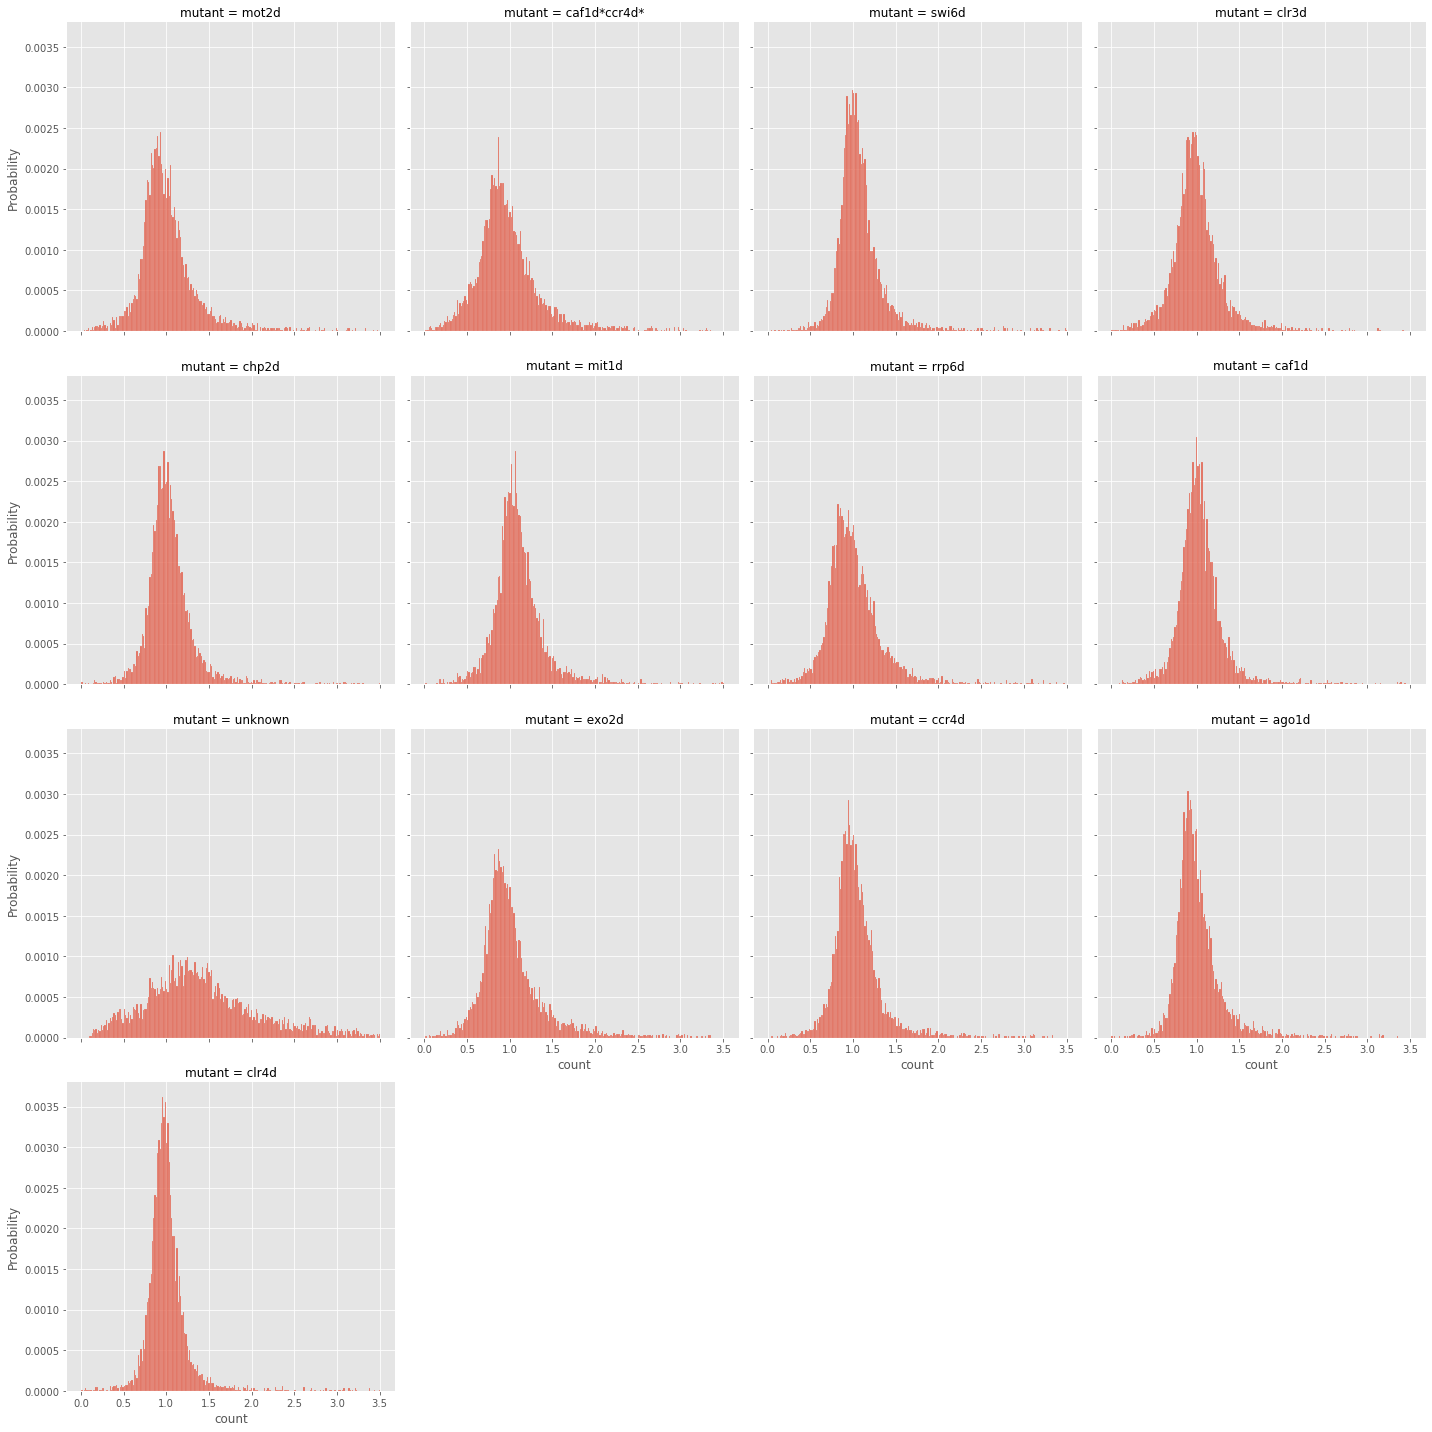

In [127]:
if (visualize_distributions):
    
    dist_plot = sns.displot(
        #data=wt_po_tidy_df, 
        data=wt_po_tidy_df[wt_po_tidy_df['count'] < max_count], 
        x="count", 
        #hue="seq_category", 
        col="mutant",
        col_wrap=4,
        stat="probability",
        #bins=200
    )
    
    wt_po_dist_fig = os.path.join(ratios_dir, 'wt_po_ratios_dist.pdf')
    print(wt_po_dist_fig)
    dist_plot.savefig(wt_po_dist_fig)

## **II.** **PO** fold change - `mutants / clr4D`

- Define pairwise **Ratios** between `80_ChIP (clr4D)` and the rest of `ChIP` **mutant samples**:

In [128]:
## fix `'80_S2-ChIP` sample
if (not h3k9me2_analysis):
    #denum = '80_S2-ChIP'
    denum = '80_' + ip_type + '-ChIP'
else:
    denum = '80_H3K9me2'

clr4_pairs = {x.split('_')[0]:(x, denum) for x in enum_delta_chip if x != denum}
clr4_pairs

{'1022': ('1022_S2-ChIP', '80_S2-ChIP'),
 '1168': ('1168_S2-ChIP', '80_S2-ChIP'),
 '301': ('301_S2-ChIP', '80_S2-ChIP'),
 '302': ('302_S2-ChIP', '80_S2-ChIP'),
 '324': ('324_S2-ChIP', '80_S2-ChIP'),
 '491': ('491_S2-ChIP', '80_S2-ChIP'),
 '504': ('504_S2-ChIP', '80_S2-ChIP'),
 '510': ('510_S2-ChIP', '80_S2-ChIP'),
 '523': ('523_S2-ChIP', '80_S2-ChIP'),
 '530': ('530_S2-ChIP', '80_S2-ChIP'),
 '544': ('544_S2-ChIP', '80_S2-ChIP'),
 '638': ('638_S2-ChIP', '80_S2-ChIP'),
 'WT': ('WT_S2-ChIP', '80_S2-ChIP')}

- Compute actual **ratios** for defined **pairing**:

In [129]:
delta_chip_clr4_file = ip_type + '-delta_chip_clr4.csv' if ip_type == 'S5' else 'delta_chip_clr4.csv'
delta_chip_clr4_file
os.path.join(ratios_dir, delta_chip_clr4_file)

'/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/delta_chip_clr4.csv'

In [130]:
print('Use shift ratio:', shift_ratio)

delta_chip_clr4_df = Util.ratio_table(
    chip_df, clr4_pairs,
    out_dir=ratios_dir, 
    #file_name='delta_chip_clr4.csv'),
    file_name=delta_chip_clr4_file,
    #shift=0 # compute ratio (x/y), values are quite small!
    #shift=1 # compute ratio (1 + x)/(1 + y)
    shift=shift_ratio # compute ratio (1 + x)/(1 + y)
)

Use shift ratio: 0


In [131]:
delta_chip_clr4_df.head()

,gene_id,gene_name,length,type,category,bio_type,1022,1168,301,302,324,491,504,510,523,530,544,638,WT
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,1.789505,1.555724,1.252671,1.681303,2.402039,3.856273,4.053453,1.092011,6.458032,3.736722,0.432391,1.289166,2.632407
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1.671367,1.076851,1.265511,3.109361,4.485812,2.746273,8.555779,1.615853,7.810119,5.347119,1.436849,3.021492,1.601302
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,1.296168,0.247980,0.916283,0.718151,1.317178,1.499094,1.256414,0.666465,2.537088,2.581264,0.521508,0.721398,1.412935
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,1.166357,0.297681,0.241380,0.606242,1.280413,0.104680,0.494485,0.542832,2.656790,1.664647,1.270673,1.796771,0.563732


In [132]:
delta_chip_clr4_df.shape

(5159, 19)

In [133]:
#delta_chip_clr4_df[delta_chip_clr4_df['gene_id'].isin(non_degraded)][[xx for xx in df.columns if ('80' in xx) | (xx == 'gene_id')]]

- Get `samples` **columns**

In [134]:
sample_cols = []
{sample_cols.append(key) for (key, value) in clr4_pairs.items()}
len(sample_cols)
#sample_cols

13

- Problems in **ratios**

In [135]:
# zeros in numerator - 0/y
# => also converted to NaN's should be empty
delta_chip_clr4_df[(delta_chip_clr4_df[sample_cols] == 0).any(axis=1)].shape

(0, 19)

In [136]:
# zeros in denominator - x/0
delta_chip_clr4_df[(delta_chip_clr4_df[sample_cols].isnull()).any(axis=1)].shape # notice that, for H3K9me2 is huge, all mRNA genes!

(95, 19)

- <font color='blue'> **Clr4 PO fold change** </font> - Compute **summary statistics** for clr4 PO ratios

In [137]:
# Summarize statistics
summary_clr4_po_tpm_df = delta_chip_clr4_df.describe(percentiles=[.25, .5, .75, .95])[sample_cols]
summary_clr4_po_tpm_df

,1022,1168,301,302,324,491,504,510,523,530,544,638,WT
count,5105.000000,5096.000000,5106.000000,5100.000000,5106.000000,5105.000000,5103.000000,5104.000000,5104.000000,5079.000000,5104.000000,5104.000000,5104.000000
mean,1.054326,1.051450,1.114558,1.037559,1.118627,1.190246,1.074704,1.092825,1.927258,1.048926,1.129115,1.101628,1.073883
std,0.889708,2.736988,0.653697,0.994797,1.445926,1.537703,1.521713,1.334216,7.529383,0.671206,2.326012,2.492265,1.096690
min,0.064744,0.006725,0.001510,0.006694,0.030090,0.041448,0.040980,0.065393,0.056297,0.018497,0.100060,0.002969,0.023082
25%,0.857350,0.767873,0.955611,0.871126,0.915084,0.959936,0.848357,0.936778,1.029931,0.841476,0.909149,0.906276,0.919720
50%,0.975471,0.940034,1.052826,0.995082,1.025284,1.088368,0.976726,1.037893,1.398369,0.967810,1.022782,0.987370,1.020424
75%,1.128096,1.139996,1.169326,1.129812,1.149465,1.217895,1.134218,1.143570,1.891906,1.130326,1.159942,1.091842,1.125264
95%,1.565830,1.712836,1.496691,1.371792,1.447663,1.569479,1.505550,1.405247,3.434816,1.625471,1.530583,1.429601,1.377993
max,47.664290,191.133804,25.868850,59.939059,56.775430,67.880688,92.388942,85.028904,451.868665,24.971953,152.433280,168.974671,64.445193


- <font color='blue'> **Clr4 PO fold change** </font> - **Visualize distributions** of clr4 PO ratios

In [138]:
clr4_po_tidy_df = pd.melt(delta_chip_clr4_df, id_vars = id_vars, var_name = 'sample_id', value_name = 'count')
clr4_po_tidy_df = clr4_po_tidy_df.astype({'count':'float64'})

# => Atention! it's a bit tricky due to ambiguity between `mutant_id -> mutant` map
clr4_po_tidy_df.loc[:, 'mutant_id'] = clr4_po_tidy_df['sample_id']
clr4_po_tidy_df.loc[:, 'mutant'] = clr4_po_tidy_df.mutant_id.map(mut_dict)

clr4_po_tidy_df.head()

,gene_id,gene_name,length,type,category,bio_type,sample_id,count,mutant_id,mutant
0,FP565355_region_1..2120,NaN,2120,region,repeat,region,1022,1.789505,1022,mot2d
1,FP565355_region_15417..15473,NaN,57,region,repeat,region,1022,NaN,1022,mot2d
2,FP565355_region_15474..15608,NaN,135,region,repeat,region,1022,1.671367,1022,mot2d
3,FP565355_region_15609..16735,NaN,1127,region,repeat,region,1022,1.296168,1022,mot2d
4,FP565355_region_16736..16794,NaN,59,region,repeat,region,1022,1.166357,1022,mot2d


In [139]:
clr4_po_tidy_df.shape

(67067, 10)

In [140]:
#clr4_po_tidy_df['seq_category'].unique()
#clr4_po_tidy_df['mutant_id'].unique()
#clr4_po_tidy_df['mutant'].unique()

In [141]:
max_count = summary_clr4_po_tpm_df.loc['95%'].max()
#max_count = 10
print('Upper threshold for count values (otherwise it take forever):', max_count)

Upper threshold for count values (otherwise it take forever): 3.434816235785262


/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/clr4_po_ratios_dist.pdf


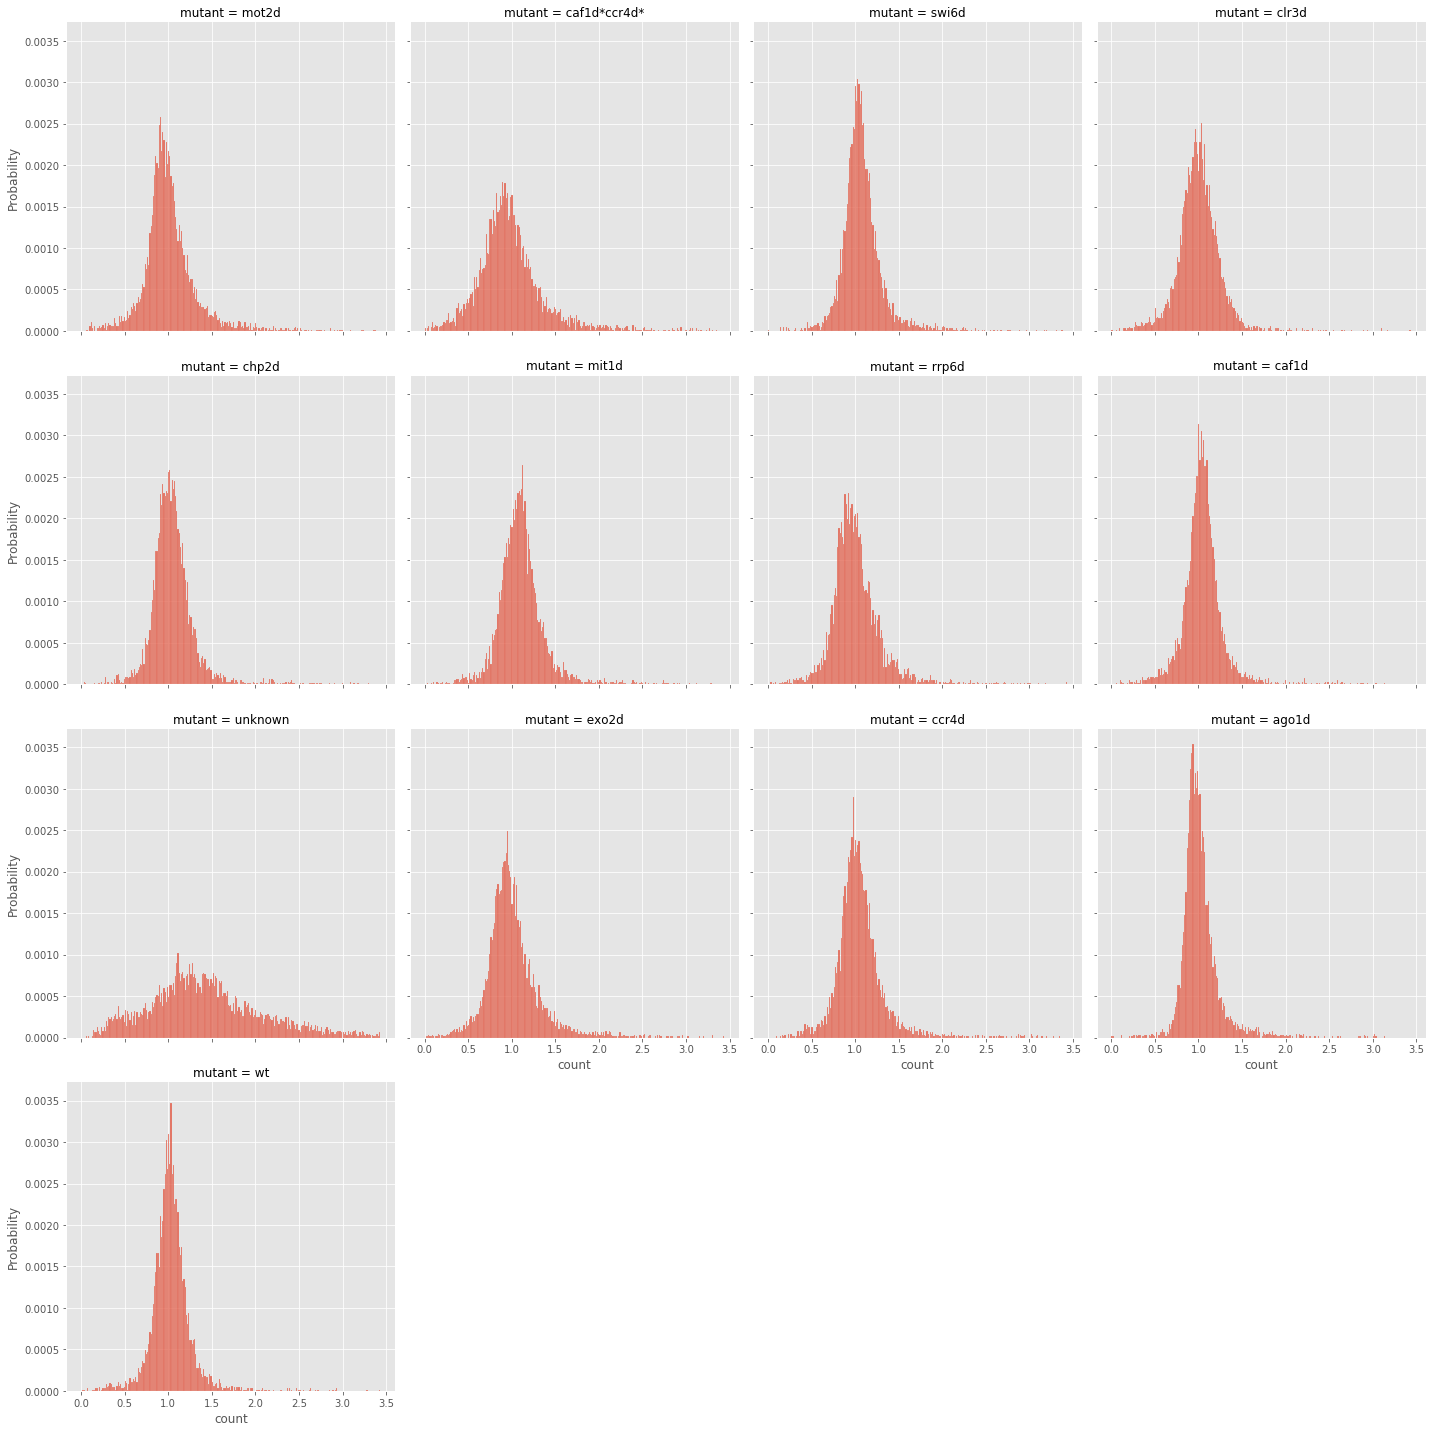

In [142]:
if (visualize_distributions):
    
    dist_plot = sns.displot(
        #data=clr4_po_tidy_df, 
        data=clr4_po_tidy_df[clr4_po_tidy_df['count'] < max_count], 
        x="count", 
        #hue="seq_category", 
        col="mutant",
        col_wrap=4,
        stat="probability",
        #bins=200
    )
    
    clr4_po_dist_fig = os.path.join(ratios_dir, 'clr4_po_ratios_dist.pdf')
    print(clr4_po_dist_fig)
    dist_plot.savefig(clr4_po_dist_fig)